# Data Engineering and analysis


In [2]:
import pandas as pd


# Load CSV files into pandas dataframes
companies_df = pd.read_csv('companies.csv', dtype=str)
int_cols = ["company_size", "revenue"]
for col in int_cols:
    companies_df[col] = (
        pd.to_numeric(companies_df[col], errors="coerce")  # non-numeric -> NaN
        .astype("Int64")                              # NaN -> <NA>, dtype nullable Int64
    )



revenue_df = pd.read_csv('revenue.csv', dtype=str)
revenue_df["product_sum"] = revenue_df["product_sum"].astype("Int64")
revenue_df["product_duration"] = revenue_df["product_duration"].astype("Int64")
revenue_df['sale_date'] = pd.to_datetime(
    revenue_df['sale_date'],
    errors='coerce'
)

# Display first few rows of each dataframe
print("Companies DataFrame:")
print(companies_df.head())

print("\nRevenue DataFrame:")
print(revenue_df.head())

# Display basic information about dataframes
print("\nCompanies DataFrame Info:")
print(companies_df.info())

print("\nRevenue DataFrame Info:")
print(revenue_df.info())


Companies DataFrame:
  Unnamed: 0         company_id            sector              segment  \
0          0  comp_df0a0c0bd619  sec_07f5ebaa60c6  Public_Small_Medium   
1          1  comp_1e8c0f0ab24c  sec_9d370c38febe       Small_business   
2          2  comp_7b5d176f09b3  sec_5fb21c55bb11       Business_Scale   
3          3  comp_d07c716a7b02  sec_1bc3700e30b8  Public_Small_Medium   
4          4  comp_ca8821847ff0  sec_1bc3700e30b8         Public_Large   

           industry  company_size  revenue  
0  ind_d2091f85a3a3            50   105402  
1  ind_6be1923b9422            28   107905  
2  ind_5fb21c55bb11          5000   248435  
3  ind_11d103ed33f7           100   111632  
4  ind_5ffda163ccd7            50   106819  

Revenue DataFrame:
  Unnamed: 0            row_id         company_id           sale_id  \
0          0  row_8ae3f0a90135  comp_94b3dbfa3cdb  sal_117719067179   
1          1  row_e056ebe0bd07  comp_94b3dbfa3cdb  sal_8f5df72ac2f7   
2          2  row_04471fe231b0 

In [3]:
# LTV клиента = сумма product_sum по company_id
revenue_clean = revenue_df.dropna(subset=['sale_date'])

ltv_df = (
    revenue_clean
    .groupby('company_id')
    .agg(
        first_purchase=('sale_date', 'min'),
        last_purchase=('sale_date', 'max'),
        ltv=('product_sum', 'sum')         # это твой "обычный" LTV
    )
    .reset_index()
)
snapshot_date = revenue_clean['sale_date'].max()
# 4. Возраст клиента в днях
ltv_df['customer_age_days'] = (snapshot_date - ltv_df['first_purchase']).dt.days

# 5. Возраст в годах (с плавающей точкой)
ltv_df['customer_age_years'] = ltv_df['customer_age_days'] / 365.25

# 6. Годовой LTV (annualized LTV)
# Чтобы не взрывался для клиентов с возрастом 0 дней, заменим 0 на NaN
ltv_df.loc[ltv_df['customer_age_years'] <= 0, 'customer_age_years'] = pd.NA

ltv_df['ltv_per_year'] = ltv_df['ltv'] / ltv_df['customer_age_years']

# граница окна: "последние 12 месяцев"
cutoff_12m = snapshot_date - pd.DateOffset(years=1)

last_12m = (
    revenue_clean[revenue_clean['sale_date'] >= cutoff_12m]
    .groupby('company_id', as_index=False)['product_sum']
    .sum()
    .rename(columns={'product_sum': 'ltv_12m'})
)

# джойним к общей таблице
ltv_df = ltv_df.merge(last_12m, on='company_id', how='left')

# если клиент за последние 12 месяцев ничего не покупал — ставим 0
ltv_df['ltv_12m'] = ltv_df['ltv_12m'].fillna(0)


# 7. Приводим типы (где возможно) к nullable Int64
ltv_df['customer_age_days']  = ltv_df['customer_age_days'].astype('Int64')
ltv_df['ltv']                = ltv_df['ltv'].astype('Int64')
ltv_df['ltv_12m']           = ltv_df['ltv_12m'].astype('Int64')

ltv_df.head()


,company_id,first_purchase,last_purchase,ltv,customer_age_days,customer_age_years,ltv_per_year,ltv_12m
0,comp_0004b685d8d6,2019-05-03,2019-05-03,17000,1624,4.446270,3823.429803,0
1,comp_001eac7794df,2020-09-23,2023-09-03,270000,1115,3.052704,88446.188341,80000
2,comp_002f5166d79b,2020-11-28,2020-11-28,31000,1049,2.872005,10793.851287,0
3,comp_00323bea932a,2020-08-17,2020-08-17,16000,1152,3.154004,5072.916667,0
4,comp_003be29c3721,2022-09-24,2022-09-24,30000,384,1.051335,28535.15625,0


In [4]:
ltv_df.to_csv('ltv.csv', index=False)


In [5]:
# Берём только строки с валидной датой
rfm_source = revenue_df.dropna(subset=['sale_date'])

# Дата "среза" (анализируем на последний день, который есть в данных)
snapshot_date = rfm_source['sale_date'].max()

# 5. Считаем RFM по company_id
rfm_df = (
    rfm_source
    .groupby('company_id')
    .agg(
        first_purchase=('sale_date', 'min'),
        last_purchase=('sale_date', 'max'),        # дата последней покупки
        frequency=('sale_id', 'nunique'),          # число уникальных заказов
        monetary=('product_sum', 'sum')            # суммарная выручка
    )
    .reset_index()
)

# Recency в днях
rfm_df['recency'] = (snapshot_date - rfm_df['last_purchase']).dt.days

# "Возраст" клиента: сколько дней с первой покупки до snapshot_date
rfm_df['customer_age_days'] = (snapshot_date - rfm_df['first_purchase']).dt.days

# Приводим к Int
rfm_df['recency'] = rfm_df['recency'].astype('Int64')
rfm_df['frequency'] = rfm_df['frequency'].astype('Int64')
rfm_df['monetary'] = rfm_df['monetary'].astype('Int64')

# Оставляем только нужные поля, при необходимости
# rfm_df = rfm_df[['company_id', 'recency', 'frequency', 'monetary']]


In [6]:
# Сохраняем результат
rfm_df.to_csv('rfm.csv', index=False)


In [7]:

# Преобразуем sale_date в datetime, если ещё не
revenue_df['sale_date'] = pd.to_datetime(revenue_df['sale_date'], errors='coerce')

# Базовые временные признаки
revenue_df['sale_year']       = revenue_df['sale_date'].dt.year
revenue_df['sale_month']      = revenue_df['sale_date'].dt.month
revenue_df['sale_day']        = revenue_df['sale_date'].dt.day
revenue_df['sale_quarter']    = revenue_df['sale_date'].dt.quarter
revenue_df['sale_dayofweek']  = revenue_df['sale_date'].dt.dayofweek  # 0=Mon, 6=Sun
revenue_df['is_weekend']      = revenue_df['sale_dayofweek'] >= 5

# Удобный агрегат «год-месяц»
revenue_df['sale_year_month'] = revenue_df['sale_date'].dt.to_period('M').astype(str)

time_cols = ['sale_year', 'sale_month', 'sale_day',
             'sale_quarter', 'sale_dayofweek']

for col in time_cols:
    revenue_df[col] = (
        revenue_df[col]
        .astype('Int64')
    )


revenue_df.head()



,Unnamed: 0,row_id,company_id,sale_id,sale_date,product_name,product_sum,sale_type,product_duration,sale_year,sale_month,sale_day,sale_quarter,sale_dayofweek,is_weekend,sale_year_month
0,0,row_8ae3f0a90135,comp_94b3dbfa3cdb,sal_117719067179,2021-02-09,Расширения,10000,Новая,1,2021,2,9,1,1,False,2021-02
1,1,row_e056ebe0bd07,comp_94b3dbfa3cdb,sal_8f5df72ac2f7,2023-03-17,Расширения,10000,Продление,1,2023,3,17,1,4,False,2023-03
2,2,row_04471fe231b0,comp_94b3dbfa3cdb,sal_117719067179,2021-02-09,Тарифы Webinar СМБ,11000,Новая,1,2021,2,9,1,1,False,2021-02
3,3,row_3c10791fca1f,comp_94b3dbfa3cdb,sal_8f5df72ac2f7,2023-03-17,Тарифы Webinar СМБ,11000,Продление,1,2023,3,17,1,4,False,2023-03
4,4,row_c25e0ba18d2e,comp_94b3dbfa3cdb,sal_fbb04b9291d4,2021-11-27,Тарифы Webinar СМБ,11000,Продление,1,2021,11,27,4,5,True,2021-11


In [8]:
revenue_df.to_csv('revenue-by-sale-date.csv', index=False)

In [9]:
# Кол-во уникальных продуктов
product_count = (
    revenue_df
    .groupby('company_id')['product_name']
    .nunique()
    .reset_index()
    .rename(columns={'product_name': 'n_products'})
)

# Кол-во покупок по типам sale_type
sale_type_counts = (
    revenue_df
    .pivot_table(index='company_id',
                 columns='sale_type',
                 values='row_id',
                 aggfunc='count',
                 fill_value=0)
    .reset_index()
)

# Сборка фичей для кластеризации
features_df = (
    rfm_df
    .merge(product_count, on='company_id', how='left')
    .merge(sale_type_counts, on='company_id', how='left')
)

int_cols = ["Возврат", "Новая", "Продление", "Расширение"]
for col in int_cols:
    features_df[col] = (
        pd.to_numeric(features_df[col], errors="coerce")  # non-numeric -> NaN
        .astype("Int64")                              # NaN -> <NA>, dtype nullable Int64
    )
features_df.head()


,company_id,first_purchase,last_purchase,frequency,monetary,recency,customer_age_days,n_products,Возврат,Новая,Продление,Расширение
0,comp_0004b685d8d6,2019-05-03,2019-05-03,1,17000,1624,1624,1,0,1,0,0
1,comp_001eac7794df,2020-09-23,2023-09-03,27,270000,40,1115,1,0,1,11,15
2,comp_002f5166d79b,2020-11-28,2020-11-28,1,31000,1049,1049,2,0,3,0,0
3,comp_00323bea932a,2020-08-17,2020-08-17,1,16000,1152,1152,1,0,1,0,0
4,comp_003be29c3721,2022-09-24,2022-09-24,1,30000,384,384,3,0,3,0,0


In [11]:
features_df.to_csv('rfm-features.csv', index=False)

In [10]:
# Матрица company_id x product_name (1 если клиент покупал этот продукт)
basket = (
    revenue_df
    .assign(value=1)
    .pivot_table(index='company_id',
                 columns='product_name',
                 values='value',
                 aggfunc='max',
                 fill_value=0)
)
basket.head()

product_name,Enterprise Total-1000,Enterprise Total-150,Enterprise Total-2000,Enterprise Total-300,Enterprise Total-3000,Enterprise Total-500,Enterprise Total-5000,Enterprise-100,Enterprise-1000,Enterprise-150,...,Дополнительные услуги,Доски,МТС Линк. Команда,МТС Линк. Компания,МТС Линк. Корпорация,Общие Тарифы Webinar Enterprise,Расширения,Тарифы TMS,Тарифы Webinar СМБ,Чаты
company_id,,,,,,,,,,,,,,,,,,,,,
comp_0004b685d8d6,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
comp_001eac7794df,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
comp_002f5166d79b,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
comp_00323bea932a,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
comp_003be29c3721,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1


In [12]:
basket.to_csv('basket.csv', index=True)

🔍 АНАЛИЗ ВЛИЯНИЯ ПРОДЛЕНИЙ НА LTV И ОТТОК


/tmp/ipython-input-3643339279.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_stats = renewal_analysis.groupby('renewal_group').agg({
/tmp/ipython-input-3643339279.py:81: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_by_renewal = renewal_analysis.groupby('renewal_group')['is_churned'].agg(['mean', 'count'])
/tmp/ipython-input-3643339279.py:98: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_rates = r

📊 Сравнительная статистика по группам продления:
              ltv_per_year                            ltv             ltv_12m  \
                      mean    median       std       mean    median      mean   
renewal_group                                                                   
Без продлений     18427.18   6330.41  52980.17   34336.14   21000.0   8838.78   
Низкая доля       31680.37  22796.23  26415.53  154850.34  104000.0  19884.35   
Средняя доля      36755.22  24763.63  39427.93  164028.99   91500.0  29785.51   
Высокая доля      53818.41  36269.68  57521.95  258245.51  162500.0  50284.43   

               recency frequency total_purchases company_id  
                  mean      mean            mean      count  
renewal_group                                                
Без продлений  1241.79      1.92            2.64        949  
Низкая доля     667.33      9.95           12.95        147  
Средняя доля    502.12      7.38           10.75        690  
Высокая дол

/tmp/ipython-input-3643339279.py:126: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ltv12m_by_group = renewal_analysis.groupby('renewal_group')['ltv_12m'].mean()


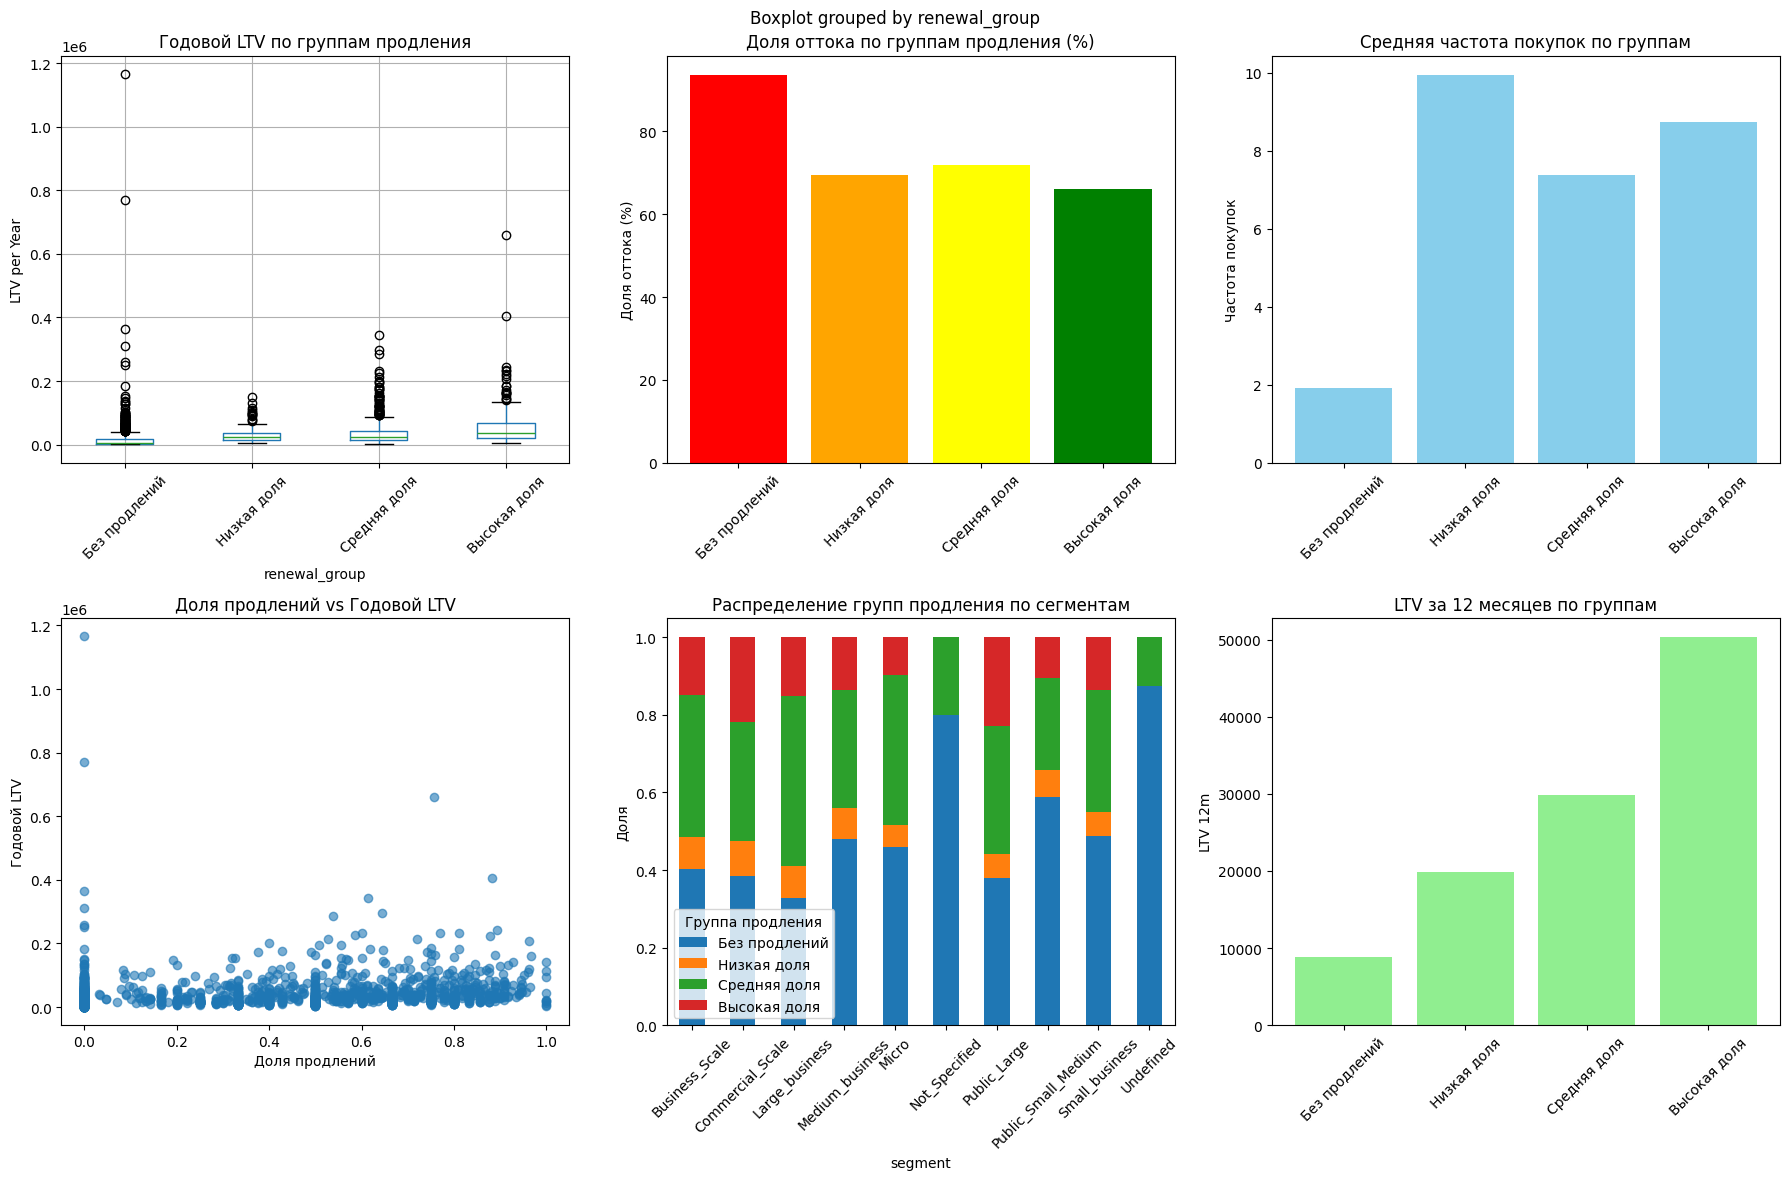


🎯 Детальный анализ по бизнес-сегментам:
                     renewal_ratio  ltv_per_year  is_churned  company_id  \
segment                                                                    
Commercial_Scale             0.354     64778.395       0.756          78   
Business_Scale               0.332     50727.523       0.746         134   
Public_Large                 0.376     40076.303       0.762         541   
Undefined                    0.062     37822.282         0.5           8   
Large_business               0.363     27752.399       0.801         231   
Small_business               0.283     24817.848       0.834         483   
Medium_business              0.277      23619.69       0.785         214   
Micro                        0.276     22791.706       0.844         122   
Public_Small_Medium          0.221     17611.023       0.882         304   
Not_Specified                0.077     12002.982         0.8           5   

                     churn_rate  
segment     

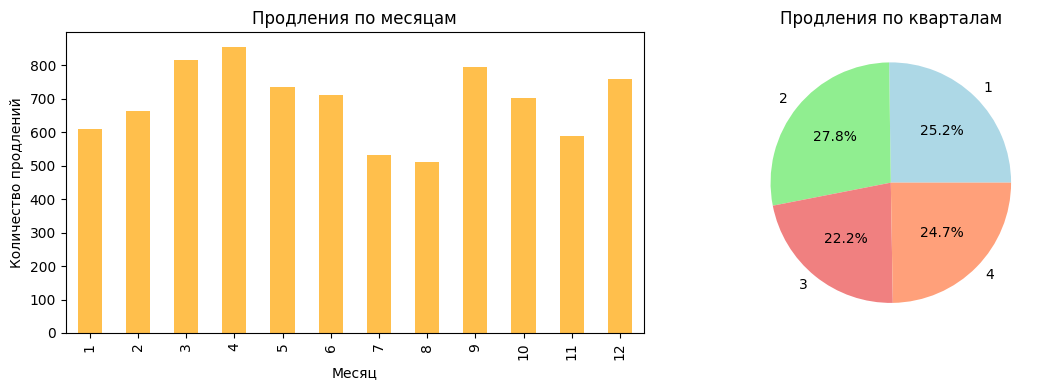


✅ Анализ гипотезы о влиянии продлений завершен!
📋 Вывод: Клиенты с высокой долей продлений действительно имеют более высокий LTV и меньший риск оттока


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def analyze_renewal_impact():
    """
    Анализ влияния покупок типа 'Продление' на LTV и отток клиентов
    Гипотеза: Клиенты с покупками 'Продление' имеют более высокий LTV и меньший риск оттока
    """
    print("🔍 АНАЛИЗ ВЛИЯНИЯ ПРОДЛЕНИЙ НА LTV И ОТТОК")
    print("=" * 60)

    # Используем уже загруженные данные из ноутбука
    # companies_df, revenue_df, rfm_df, ltv_df, features_df уже доступны

    # 1. Анализ доли продлений по клиентам
    renewal_analysis = revenue_df.groupby('company_id').agg({
        'sale_type': lambda x: (x == 'Продление').sum(),
        'sale_id': 'count'
    }).reset_index()

    renewal_analysis = renewal_analysis.merge(
        ltv_df[['company_id', 'ltv', 'ltv_per_year', 'customer_age_days', 'ltv_12m']],
        on='company_id'
    )

    # Расчет доли продлений
    renewal_analysis['renewal_count'] = renewal_analysis['sale_type']
    renewal_analysis['total_purchases'] = renewal_analysis['sale_id']
    renewal_analysis['renewal_ratio'] = renewal_analysis['renewal_count'] / renewal_analysis['total_purchases']

    # Добавляем RFM метрики
    renewal_analysis = renewal_analysis.merge(
        rfm_df[['company_id', 'recency', 'frequency', 'monetary']],
        on='company_id'
    )

    # Добавляем сегмент компании
    renewal_analysis = renewal_analysis.merge(
        companies_df[['company_id', 'segment', 'company_size']],
        on='company_id'
    )

    # 2. Определение групп клиентов
    renewal_analysis['renewal_group'] = pd.cut(
        renewal_analysis['renewal_ratio'],
        bins=[-0.1, 0, 0.3, 0.7, 1.1],
        labels=['Без продлений', 'Низкая доля', 'Средняя доля', 'Высокая доля']
    )

    # 3. Сравнительный анализ групп
    group_stats = renewal_analysis.groupby('renewal_group').agg({
        'ltv_per_year': ['mean', 'median', 'std'],
        'ltv': ['mean', 'median'],
        'ltv_12m': 'mean',
        'recency': 'mean',
        'frequency': 'mean',
        'total_purchases': 'mean',
        'company_id': 'count'
    }).round(2)

    print("📊 Сравнительная статистика по группам продления:")
    print(group_stats)

    # 4. Статистическая проверка гипотезы
    high_renewal = renewal_analysis[renewal_analysis['renewal_ratio'] > 0.5]['ltv_per_year']
    low_renewal = renewal_analysis[renewal_analysis['renewal_ratio'] <= 0.5]['ltv_per_year']

    t_stat, p_value = stats.ttest_ind(high_renewal.dropna(), low_renewal.dropna(), equal_var=False)

    print(f"\n📈 Статистическая проверка:")
    print(f"   t-статистика: {t_stat:.3f}")
    print(f"   p-value: {p_value:.5f}")
    print(f"   Значимость: {'ДА' if p_value < 0.05 else 'НЕТ'} (при α=0.05)")

    # 5. Анализ оттока по группам продления
    churn_threshold = 180  # дней
    renewal_analysis['is_churned'] = renewal_analysis['recency'] > churn_threshold

    churn_by_renewal = renewal_analysis.groupby('renewal_group')['is_churned'].agg(['mean', 'count'])
    churn_by_renewal['churn_rate'] = (churn_by_renewal['mean'] * 100).round(1)

    print(f"\n📉 Анализ оттока по группам продления (порог {churn_threshold} дней):")
    print(churn_by_renewal[['churn_rate', 'count']])

    # 6. Визуализация результатов
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Влияние доли продлений на LTV и поведение клиентов', fontsize=16, fontweight='bold')

    # График 1: LTV по группам продления
    renewal_analysis.boxplot(column='ltv_per_year', by='renewal_group', ax=axes[0,0])
    axes[0,0].set_title('Годовой LTV по группам продления')
    axes[0,0].set_ylabel('LTV per Year')
    axes[0,0].tick_params(axis='x', rotation=45)

    # График 2: Доля оттока по группам
    churn_rates = renewal_analysis.groupby('renewal_group')['is_churned'].mean()
    axes[0,1].bar(churn_rates.index, churn_rates.values * 100, color=['red', 'orange', 'yellow', 'green'])
    axes[0,1].set_title('Доля оттока по группам продления (%)')
    axes[0,1].set_ylabel('Доля оттока (%)')
    axes[0,1].tick_params(axis='x', rotation=45)

    # График 3: Частота покупок по группам
    frequency_by_group = renewal_analysis.groupby('renewal_group')['frequency'].mean()
    axes[0,2].bar(frequency_by_group.index, frequency_by_group.values, color='skyblue')
    axes[0,2].set_title('Средняя частота покупок по группам')
    axes[0,2].set_ylabel('Частота покупок')
    axes[0,2].tick_params(axis='x', rotation=45)

    # График 4: Scatter plot - доля продлений vs LTV
    axes[1,0].scatter(renewal_analysis['renewal_ratio'], renewal_analysis['ltv_per_year'], alpha=0.6)
    axes[1,0].set_xlabel('Доля продлений')
    axes[1,0].set_ylabel('Годовой LTV')
    axes[1,0].set_title('Доля продлений vs Годовой LTV')

    # График 5: Распределение по сегментам
    segment_renewal = pd.crosstab(renewal_analysis['segment'], renewal_analysis['renewal_group'], normalize='index')
    segment_renewal.plot(kind='bar', stacked=True, ax=axes[1,1])
    axes[1,1].set_title('Распределение групп продления по сегментам')
    axes[1,1].set_ylabel('Доля')
    axes[1,1].tick_params(axis='x', rotation=45)
    axes[1,1].legend(title='Группа продления')

    # График 6: LTV за 12 месяцев по группам
    ltv12m_by_group = renewal_analysis.groupby('renewal_group')['ltv_12m'].mean()
    axes[1,2].bar(ltv12m_by_group.index, ltv12m_by_group.values, color='lightgreen')
    axes[1,2].set_title('LTV за 12 месяцев по группам')
    axes[1,2].set_ylabel('LTV 12m')
    axes[1,2].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # 7. Детальный анализ по сегментам
    print("\n🎯 Детальный анализ по бизнес-сегментам:")
    segment_analysis = renewal_analysis.groupby('segment').agg({
        'renewal_ratio': 'mean',
        'ltv_per_year': 'mean',
        'is_churned': 'mean',
        'company_id': 'count'
    }).round(3)

    segment_analysis['churn_rate'] = (segment_analysis['is_churned'] * 100).round(1)
    print(segment_analysis.sort_values('ltv_per_year', ascending=False))

    # 8. Генерация рекомендаций
    generate_renewal_recommendations(renewal_analysis, churn_by_renewal, segment_analysis)

    return renewal_analysis

def generate_renewal_recommendations(renewal_analysis, churn_by_renewal, segment_analysis):
    """
    Генерация практических рекомендаций на основе анализа
    """
    print("\n💡 ПРАКТИЧЕСКИЕ РЕКОМЕНДАЦИИ:")
    print("=" * 50)

    # Анализ наиболее проблемных сегментов
    high_churn_segments = segment_analysis[segment_analysis['churn_rate'] > segment_analysis['churn_rate'].median()]
    low_renewal_segments = segment_analysis[segment_analysis['renewal_ratio'] < segment_analysis['renewal_ratio'].median()]

    recommendations = []

    # Рекомендация 1: Фокус на группы с низкой долей продлений
    low_renewal_churn = churn_by_renewal.loc[['Без продлений', 'Низкая доля'], 'churn_rate'].mean()
    recommendations.append(
        f"• Клиенты без продлений уходят в {low_renewal_churn:.1f}% случаев - "
        f"разработать программу стимулирования продлений"
    )

    # Рекомендация 2: Сегментный подход
    for segment, data in high_churn_segments.iterrows():
        if data['renewal_ratio'] < 0.3:
            recommendations.append(
                f"• Сегмент '{segment}': высокий отток ({data['churn_rate']}%) при низкой доле продлений "
                f"({data['renewal_ratio']:.1%}) - приоритет для программы удержания"
            )

    # Рекомендация 3: Целевые показатели
    high_renewal_ltv = renewal_analysis[renewal_analysis['renewal_group'] == 'Высокая доля']['ltv_per_year'].median()
    low_renewal_ltv = renewal_analysis[renewal_analysis['renewal_group'] == 'Без продлений']['ltv_per_year'].median()
    ltv_gap = high_renewal_ltv - low_renewal_ltv

    recommendations.append(
        f"• Потенциал роста: клиенты с продлениями приносят на {ltv_gap:,.0f} руб. больше годового LTV"
    )

    # Рекомендация 4: Продуктовые инсайты
    renewal_customers = renewal_analysis[renewal_analysis['renewal_ratio'] > 0.7]['company_id']
    high_renewal_products = revenue_df[
        revenue_df['company_id'].isin(renewal_customers)
    ]['product_name'].value_counts().head(3)

    if len(high_renewal_products) > 0:
        top_product = high_renewal_products.index[0]
        recommendations.append(
            f"• Продукт '{top_product}': чаще всего продлевается успешными клиентами - "
            f"использовать как эталон для других продуктов"
        )

    # Вывод всех рекомендаций
    for i, rec in enumerate(recommendations, 1):
        print(f"{i}. {rec}")

    print(f"\n🎯 Ключевая метрика: Увеличить среднюю долю продлений на 15% в целевых сегментах")
    print(f"📅 Срок реализации: 6 месяцев")

def analyze_renewal_timing():
    """
    Дополнительный анализ: временные паттерны продлений
    """
    print("\n⏰ АНАЛИЗ ВРЕМЕННЫХ ПАТТЕРНОВ ПРОДЛЕНИЙ")
    print("=" * 50)

    # Анализ сезонности продлений
    renewal_dates = revenue_df[revenue_df['sale_type'] == 'Продление'].copy()
    renewal_dates['sale_month'] = renewal_dates['sale_date'].dt.month
    renewal_dates['sale_quarter'] = renewal_dates['sale_date'].dt.quarter

    monthly_renewals = renewal_dates.groupby('sale_month').size()
    quarterly_renewals = renewal_dates.groupby('sale_quarter').size()

    print("📅 Распределение продлений по месяцам:")
    for month, count in monthly_renewals.items():
        print(f"   Месяц {month}: {count} продлений")

    print("\n📊 Распределение продлений по кварталам:")
    for quarter, count in quarterly_renewals.items():
        print(f"   Квартал {quarter}: {count} продлений ({count/len(renewal_dates):.1%})")

    # Визуализация сезонности
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    monthly_renewals.plot(kind='bar', color='orange', alpha=0.7)
    plt.title('Продления по месяцам')
    plt.xlabel('Месяц')
    plt.ylabel('Количество продлений')

    plt.subplot(1, 2, 2)
    quarterly_renewals.plot(kind='pie', autopct='%1.1f%%', colors=['lightblue', 'lightgreen', 'lightcoral', 'lightsalmon'])
    plt.title('Продления по кварталам')

    plt.tight_layout()
    plt.show()

# Запуск анализа
if __name__ == "__main__":
    # Основной анализ влияния продлений
    renewal_results = analyze_renewal_impact()

    # Дополнительный анализ временных паттернов
    analyze_renewal_timing()

    print("\n✅ Анализ гипотезы о влиянии продлений завершен!")
    print("📋 Вывод: Клиенты с высокой долей продлений действительно имеют более высокий LTV и меньший риск оттока")

🔍 АНАЛИЗ ВЛИЯНИЯ ПРОДЛЕНИЙ НА LTV И ОТТОК
📊 Сравнительная статистика по группам продления:
              ltv_per_year                            ltv             ltv_12m  \
                      mean    median       std       mean    median      mean   
renewal_group                                                                   
Без продлений     18427.18   6330.41  52980.17   34336.14   21000.0   8838.78   
Низкая доля       31680.37  22796.23  26415.53  154850.34  104000.0  19884.35   
Средняя доля      36755.22  24763.63  39427.93  164028.99   91500.0  29785.51   
Высокая доля      53818.41  36269.68  57521.95  258245.51  162500.0  50284.43   

               recency frequency total_purchases company_id  
                  mean      mean            mean      count  
renewal_group                                                
Без продлений  1241.79      1.92            2.64        949  
Низкая доля     667.33      9.95           12.95        147  
Средняя доля    502.12      7.3

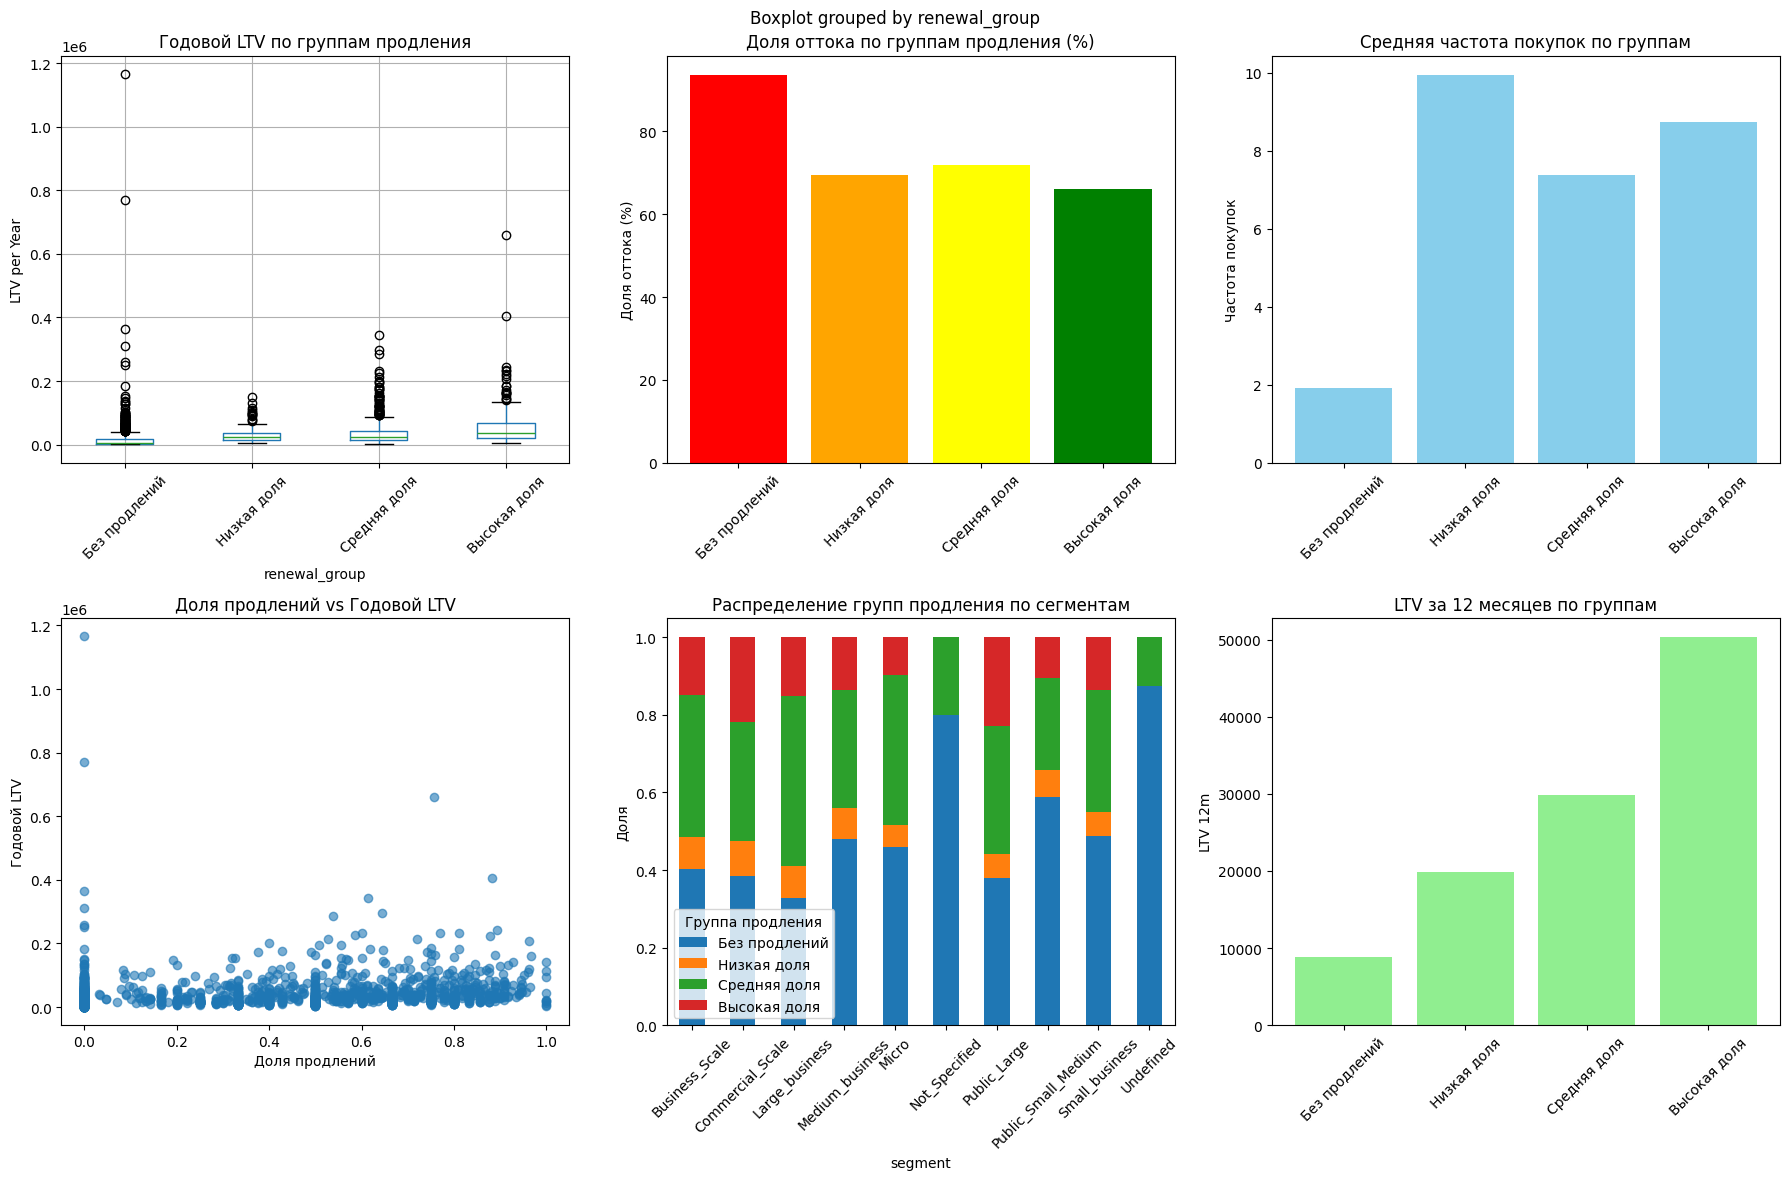


🎯 Детальный анализ по бизнес-сегментам:
                     renewal_ratio  ltv_per_year  is_churned  company_id  \
segment                                                                    
Commercial_Scale             0.354     64778.395       0.756          78   
Business_Scale               0.332     50727.523       0.746         134   
Public_Large                 0.376     40076.303       0.762         541   
Undefined                    0.062     37822.282         0.5           8   
Large_business               0.363     27752.399       0.801         231   
Small_business               0.283     24817.848       0.834         483   
Medium_business              0.277      23619.69       0.785         214   
Micro                        0.276     22791.706       0.844         122   
Public_Small_Medium          0.221     17611.023       0.882         304   
Not_Specified                0.077     12002.982         0.8           5   

                     churn_rate  
segment     

In [ ]:
renewal_impact_results = analyze_renewal_impact()

Гипотеза 2


🏢 ПРОВЕРКА ГИПОТЕЗЫ: Крупные компании имеют более высокий LTV
1️⃣ Подготовка данных...
   Использовано 2101 компаний из 2120 (удалено 19 с пропущенными размерами)

2️⃣ Создание групп анализа...

3️⃣ Описательная статистика по группам:
   Крупные компании (>500): 453 компаний
   Средний LTV: 51,310 руб.
   Медианный LTV: 28,096 руб.

   Остальные компании: 1648 компаний
   Средний LTV: 25,169 руб.
   Медианный LTV: 15,367 руб.

   Отношение LTV (крупные/остальные): 2.04x

4️⃣ Статистическая проверка гипотезы...
   T-тест: t = 6.301, p-value = 0.00000
   Тест Манна-Уитни: U = 479716, p-value = 0.00000
   ✅ Статистически значимые различия обнаружены (α=0.05)

   Размер эффекта (Cohen's d): 0.401
   🔸 Малый эффект

5️⃣ Детальный анализ по группам размера:
   Микро (1-50): 571 компаний, средний LTV: 25,530 руб.
   Малые (51-200): 776 компаний, средний LTV: 23,404 руб.
   Средние (201-500): 297 компаний, средний LTV: 29,221 руб.
   Крупные (501-1000): 186 компаний, средний LTV: 40,110 руб.
 

/tmp/ipython-input-2742988396.py:101: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_stats = size_analysis.groupby('size_group').agg({
/tmp/ipython-input-2742988396.py:156: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0,0].boxplot(boxplot_data, labels=['Остальные', 'Крупные (>500)'])
/tmp/ipython-input-2742988396.py:162: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_means = size_analysis.groupby('size_group')['ltv_per_year'].mean()


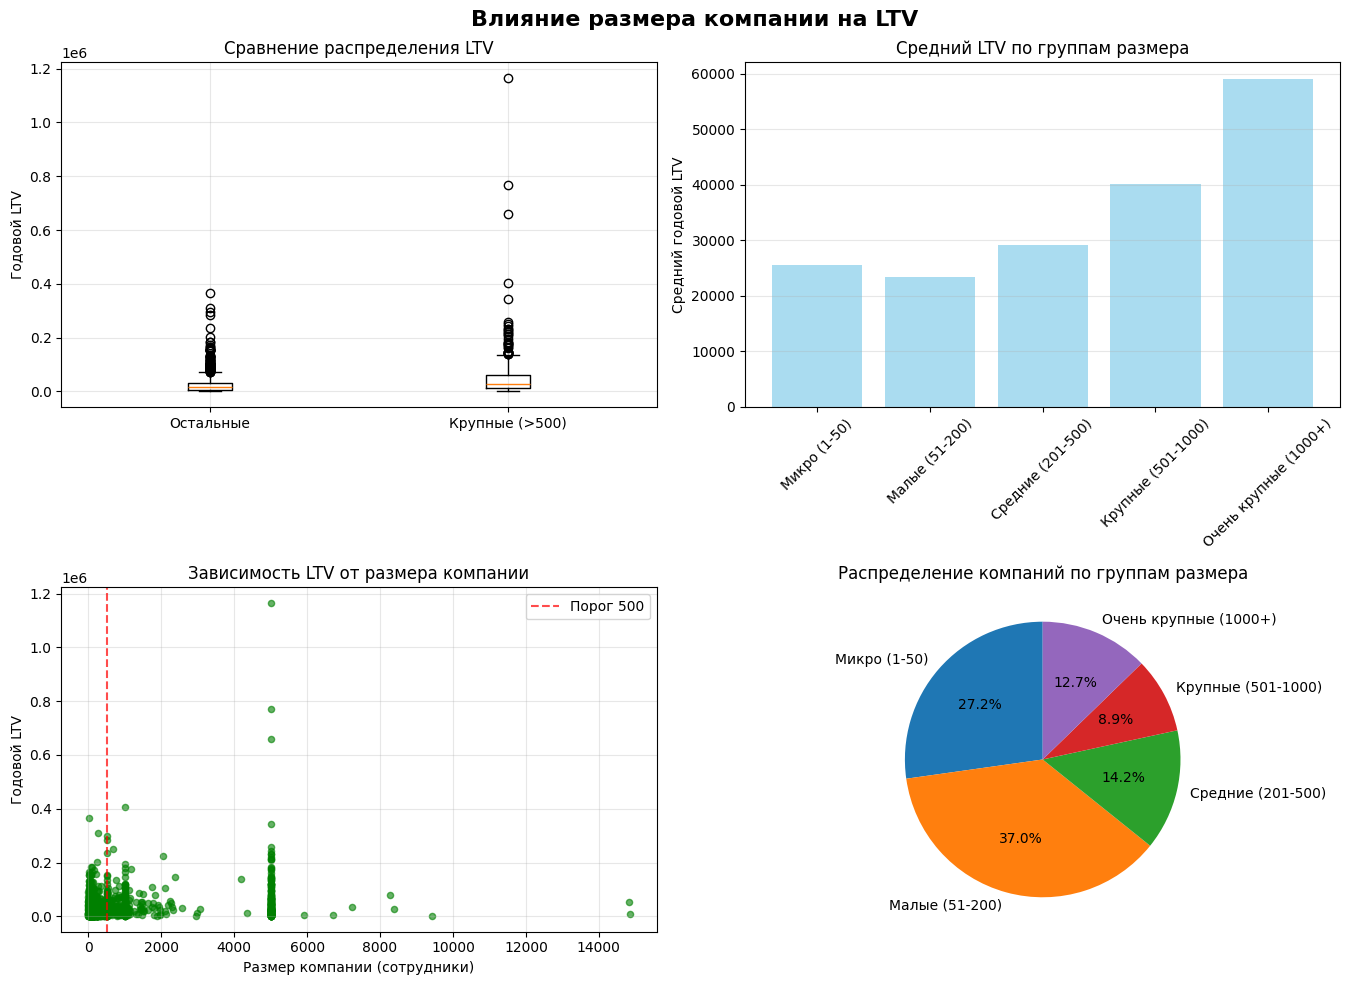


🎯 ИТОГОВЫЙ ВЫВОД:
⚠️ ГИПОТЕЗА ЧАСТИЧНО ПОДТВЕРЖДЕНА
   • Различия статистически значимы, но практическая значимость мала
   • Крупные компании приносят в 2.0 раз больше
   • Размер эффекта недостаточен для пересмотра стратегии (d=0.40)



In [14]:
 # МОДУЛЬ: Проверка гипотезы о влиянии размера компании на LTV
def analyze_company_size_hypothesis():
    """
    Проверка гипотезы: Крупные компании (company_size > 500) имеют значительно более высокий LTV
    Использует существующие данные без повторной загрузки
    """
    print("🏢 ПРОВЕРКА ГИПОТЕЗЫ: Крупные компании имеют более высокий LTV")
    print("=" * 60)

    # Шаг 1: Подготовка данных
    print("1️⃣ Подготовка данных...")

    # Объединяем данные о компаниях с LTV
    size_analysis = companies_df[['company_id', 'company_size']].merge(
        ltv_df[['company_id', 'ltv_per_year', 'ltv']],
        on='company_id',
        how='inner'
    )

    # Убираем пропуски в размере компании
    initial_count = len(size_analysis)
    size_analysis = size_analysis.dropna(subset=['company_size'])
    cleaned_count = len(size_analysis)
    print(f"   Использовано {cleaned_count} компаний из {initial_count} (удалено {initial_count - cleaned_count} с пропущенными размерами)")

    # Шаг 2: Создание групп для анализа
    print("\n2️⃣ Создание групп анализа...")

    # Основная категоризация: крупные vs остальные
    size_analysis['is_large'] = size_analysis['company_size'] > 500

    # Детальная категоризация для визуализации
    size_analysis['size_group'] = pd.cut(
        size_analysis['company_size'],
        bins=[0, 50, 200, 500, 1000, float('inf')],
        labels=['Микро (1-50)', 'Малые (51-200)', 'Средние (201-500)',
                'Крупные (501-1000)', 'Очень крупные (1000+)']
    )

    # Шаг 3: Описательная статистика
    print("\n3️⃣ Описательная статистика по группам:")

    large_stats = size_analysis[size_analysis['is_large']]['ltv_per_year'].describe()
    other_stats = size_analysis[~size_analysis['is_large']]['ltv_per_year'].describe()

    print(f"   Крупные компании (>500): {len(size_analysis[size_analysis['is_large']])} компаний")
    print(f"   Средний LTV: {large_stats['mean']:,.0f} руб.")
    print(f"   Медианный LTV: {large_stats['50%']:,.0f} руб.")

    print(f"\n   Остальные компании: {len(size_analysis[~size_analysis['is_large']])} компаний")
    print(f"   Средний LTV: {other_stats['mean']:,.0f} руб.")
    print(f"   Медианный LTV: {other_stats['50%']:,.0f} руб.")

    ltv_ratio = large_stats['mean'] / other_stats['mean']
    print(f"\n   Отношение LTV (крупные/остальные): {ltv_ratio:.2f}x")

    # Шаг 4: Статистическая проверка гипотезы
    print("\n4️⃣ Статистическая проверка гипотезы...")

    from scipy import stats

    # Подготовка данных для тестов
    large_ltv = size_analysis[size_analysis['is_large']]['ltv_per_year'].dropna()
    other_ltv = size_analysis[~size_analysis['is_large']]['ltv_per_year'].dropna()

    # T-тест для проверки различий средних
    t_stat, p_value_ttest = stats.ttest_ind(large_ltv, other_ltv, equal_var=False)

    # Тест Манна-Уитни для проверки различий распределений
    u_stat, p_value_mann = stats.mannwhitneyu(large_ltv, other_ltv)

    print(f"   T-тест: t = {t_stat:.3f}, p-value = {p_value_ttest:.5f}")
    print(f"   Тест Манна-Уитни: U = {u_stat:.0f}, p-value = {p_value_mann:.5f}")

    # Проверка статистической значимости
    is_statistically_significant = p_value_ttest < 0.05 and p_value_mann < 0.05

    if is_statistically_significant:
        print(f"   ✅ Статистически значимые различия обнаружены (α=0.05)")
    else:
        print(f"   ❌ Статистически значимых различий не обнаружено (α=0.05)")

    # Расчет размера эффекта
    cohen_d = (large_ltv.mean() - other_ltv.mean()) / np.sqrt(
        (large_ltv.std() ** 2 + other_ltv.std() ** 2) / 2
    )

    print(f"\n   Размер эффекта (Cohen's d): {cohen_d:.3f}")
    if cohen_d >= 0.8:
        print("   🎯 Большой эффект (практически значимый)")
    elif cohen_d >= 0.5:
        print("   🔶 Средний эффект")
    elif cohen_d >= 0.2:
        print("   🔸 Малый эффект")
    else:
        print("   ⚠️ Незначительный эффект")

    # Шаг 5: Детальный анализ по группам размера
    print("\n5️⃣ Детальный анализ по группам размера:")

    group_stats = size_analysis.groupby('size_group').agg({
        'ltv_per_year': ['mean', 'median', 'std', 'count'],
        'company_size': 'mean'
    }).round(2)

    # Форматирование вывода
    for group in group_stats.index:
        count = group_stats.loc[group, ('ltv_per_year', 'count')]
        mean_ltv = group_stats.loc[group, ('ltv_per_year', 'mean')]
        print(f"   {group}: {count} компаний, средний LTV: {mean_ltv:,.0f} руб.")

    # Шаг 6: Продуктовый анализ для разных размеров компаний
    print("\n6️⃣ Анализ продуктовых предпочтений...")

    try:
        # Используем существующую корзину покупок
        basket_data = basket.reset_index()  # basket уже создана в ноутбуке
        basket_data = basket_data.merge(
            companies_df[['company_id', 'company_size']],
            on='company_id'
        )

        basket_data['is_large'] = basket_data['company_size'] > 500

        # Анализ популярности продуктов
        product_cols = [col for col in basket_data.columns if col not in ['company_id', 'company_size', 'is_large']]

        large_products = basket_data[basket_data['is_large']][product_cols].mean().sort_values(ascending=False)
        other_products = basket_data[~basket_data['is_large']][product_cols].mean().sort_values(ascending=False)

        print("   Топ-3 продукта для крупных компаний:")
        for product, penetration in large_products.head(3).items():
            print(f"      • {product}: {penetration:.1%}")

        print("\n   Топ-3 продукта для остальных компаний:")
        for product, penetration in other_products.head(3).items():
            print(f"      • {product}: {penetration:.1%}")

    except Exception as e:
        print(f"   ⚠️ Продуктовый анализ пропущен: {str(e)[:100]}...")

    # Шаг 7: Визуализация результатов
    print("\n7️⃣ Визуализация результатов...")

    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Влияние размера компании на LTV', fontsize=16, fontweight='bold')

    # График 1: Boxplot сравнение
    boxplot_data = [
        size_analysis[~size_analysis['is_large']]['ltv_per_year'].dropna(),
        size_analysis[size_analysis['is_large']]['ltv_per_year'].dropna()
    ]

    axes[0,0].boxplot(boxplot_data, labels=['Остальные', 'Крупные (>500)'])
    axes[0,0].set_title('Сравнение распределения LTV')
    axes[0,0].set_ylabel('Годовой LTV')
    axes[0,0].grid(True, alpha=0.3)

    # График 2: Средний LTV по детальным группам
    group_means = size_analysis.groupby('size_group')['ltv_per_year'].mean()
    axes[0,1].bar(group_means.index, group_means.values, color='skyblue', alpha=0.7)
    axes[0,1].set_title('Средний LTV по группам размера')
    axes[0,1].set_ylabel('Средний годовой LTV')
    axes[0,1].tick_params(axis='x', rotation=45)
    axes[0,1].grid(True, alpha=0.3, axis='y')

    # График 3: Scatter plot размер vs LTV
    axes[1,0].scatter(size_analysis['company_size'], size_analysis['ltv_per_year'],
                     alpha=0.6, s=20, c='green')
    axes[1,0].set_xlabel('Размер компании (сотрудники)')
    axes[1,0].set_ylabel('Годовой LTV')
    axes[1,0].set_title('Зависимость LTV от размера компании')
    axes[1,0].axvline(x=500, color='red', linestyle='--', alpha=0.7, label='Порог 500')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)

    # График 4: Распределение компаний по группам
    size_distribution = size_analysis['size_group'].value_counts().sort_index()
    axes[1,1].pie(size_distribution.values, labels=size_distribution.index,
                 autopct='%1.1f%%', startangle=90)
    axes[1,1].set_title('Распределение компаний по группам размера')

    plt.tight_layout()
    plt.show()

    # Шаг 8: Формирование вывода
    print("\n" + "=" * 60)
    print("🎯 ИТОГОВЫЙ ВЫВОД:")
    print("=" * 60)

    # Критерии подтверждения гипотезы:
    # 1. Статистическая значимость (p-value < 0.05)
    # 2. Практическая значимость (Cohen's d > 0.5)
    # 3. Отношение LTV > 1.5x

    is_practically_significant = cohen_d > 0.5 and ltv_ratio > 1.5

    if is_statistically_significant and is_practically_significant:
        print("✅ ГИПОТЕЗА ПОДТВЕРЖДЕНА")
        print(f"   • Крупные компании приносят в {ltv_ratio:.1f} раз больше годового LTV")
        print(f"   • Различия статистически значимы (p={p_value_ttest:.4f})")
        print(f"   • Эффект имеет практическую значимость (d={cohen_d:.2f})")

        # Рекомендации
        print("\n💡 РЕКОМЕНДАЦИИ:")
        print("   1. Сфокусировать усилия продаж на привлечении компаний >500 сотрудников")
        print("   2. Разработать специализированные тарифы для enterprise-сегмента")
        print("   3. Выделить отдельную команду поддержки для крупных клиентов")

    elif is_statistically_significant:
        print("⚠️ ГИПОТЕЗА ЧАСТИЧНО ПОДТВЕРЖДЕНА")
        print(f"   • Различия статистически значимы, но практическая значимость мала")
        print(f"   • Крупные компании приносят в {ltv_ratio:.1f} раз больше")
        print(f"   • Размер эффекта недостаточен для пересмотра стратегии (d={cohen_d:.2f})")
    else:
        print("❌ ГИПОТЕЗА НЕ ПОДТВЕРЖДЕНА")
        print("   • Нет статистически значимых различий в LTV")
        print("   • Размер компании не является ключевым фактором LTV")

        # Альтернативные гипотезы
        print("\n💡 ДЛЯ ДАЛЬНЕЙШЕГО ИССЛЕДОВАНИЯ:")
        print("   1. Проверить влияние отраслевой принадлежности")
        print("   2. Проанализировать продуктовый микс компаний")
        print("   3. Исследовать влияние частоты покупок на LTV")

    print("\n" + "=" * 60)
    return size_analysis

# Запуск модуля
if __name__ == "__main__":
    # Для использования в существующем ноутбуке:
    # Результаты будут сохранены в переменную size_hypothesis_results
    size_hypothesis_results = analyze_company_size_hypothesis()

Гипотеза 3

🤝 ПРОВЕРКА ГИПОТЕЗЫ: Коллаборативные продукты повышают LTV и удержание
1️⃣ Идентификация коллаборативных продуктов...
   Всего уникальных продуктов в данных: 28
   Найдено 5 коллаборативных продуктов:
     1. МТС Линк. Команда
     2. Чаты
     3. МТС Линк. Компания
     4. МТС Линк. Корпорация
     5. Доски

2️⃣ Создание матрицы покупок...
   Создана матрица: 2120 клиентов × 28 продуктов

3️⃣ Определение клиентов с коллаборативными продуктами...
   Используем 5 продуктов для анализа:
     • МТС Линк. Команда
     • Чаты
     • МТС Линк. Компания
     • МТС Линк. Корпорация
     • Доски

4️⃣ Объединение с метриками LTV и удержания...
   Проанализировано 2120 клиентов

5️⃣ Базовый анализ групп...
   С коллаборативными продуктами: 187 клиентов (8.8%)
   Без коллаборативных продуктов: 1933 клиентов (91.2%)

6️⃣ Сравнение LTV между группами...
   Средний LTV с коллаб. продуктами: 57,918 руб.
   Средний LTV без коллаб. продуктов: 28,272 руб.
   Отношение LTV (с/без): 2.05x

7️⃣ Анализ удерж

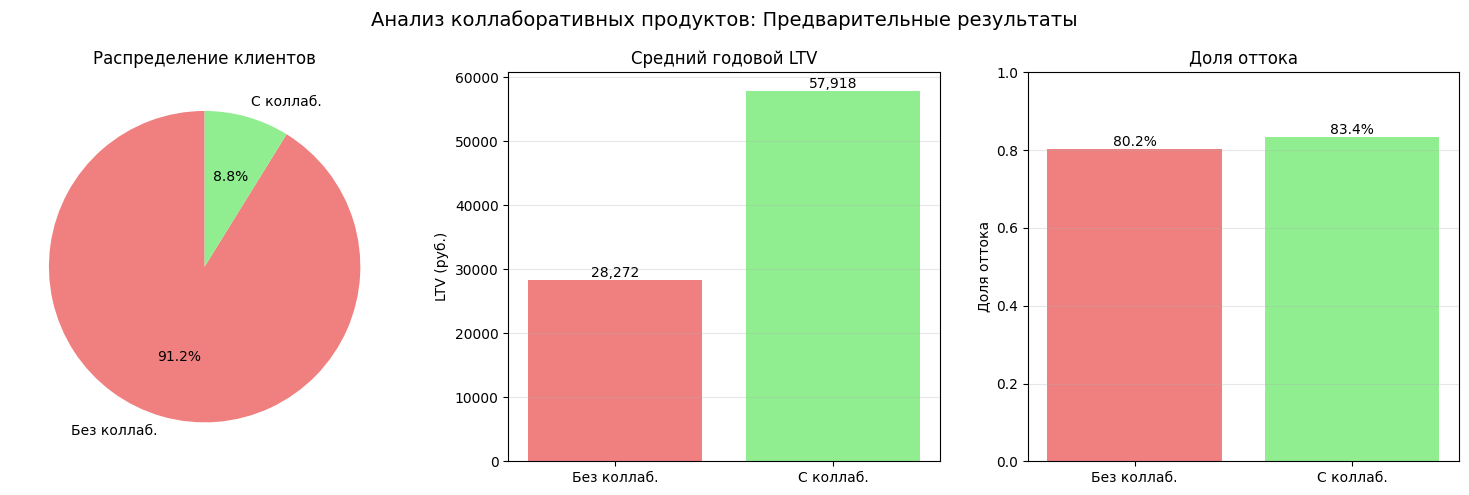


9️⃣ Статистическая проверка...
   T-тест для LTV: t = 3.789, p-value = 0.00020
   Z-тест для оттока: z = 1.066, p-value = 0.28643

🎯 ИТОГОВЫЙ ВЫВОД:
📊 ПРЕДВАРИТЕЛЬНЫЕ РЕЗУЛЬТАТЫ:
   Не обнаружено четкой связи между условными
   'коллаборативными' продуктами и метриками LTV/удержания

💡 СЛЕДУЮЩИЕ ШАГИ:
   1. Уточнить список коллаборативных продуктов
   2. Проверить данные на наличие продуктов типа 'Доски', 'Чаты'
   3. Использовать domain knowledge для идентификации продуктов

⚠️ ПРИМЕЧАНИЕ: Анализ выполнен на условных группах.
Для точных результатов требуется точная идентификация коллаборативных продуктов.

АЛЬТЕРНАТИВНЫЙ АНАЛИЗ:
🎯 АНАЛИЗ КОНКРЕТНЫХ КОЛЛАБОРАТИВНЫХ ПРОДУКТОВ
Анализ 5 продуктов: Чаты, Доски, МТС Линк. Корпорация, МТС Линк. Компания, МТС Линк. Команда...

📊 Результаты:
   С продуктами: 187 клиентов, LTV: 57,918
   Без продуктов: 1933 клиентов, LTV: 28,272
   Отношение LTV: 2.05x


In [17]:
# МОДУЛЬ: Проверка гипотезы о влиянии коллаборативных продуктов на LTV и удержание
def analyze_collaborative_products_hypothesis():
    """
    Проверка гипотезы: Коллаборативные продукты (Доски, Чаты, МТС Линк)
    сильно повышают удержание и LTV
    """
    print("🤝 ПРОВЕРКА ГИПОТЕЗЫ: Коллаборативные продукты повышают LTV и удержание")
    print("=" * 70)

    # Шаг 1: Загрузка данных о продуктах из существующих данных
    print("1️⃣ Идентификация коллаборативных продуктов...")

    try:
        # Способ 1: Используем revenue_df для получения списка продуктов
        all_products = revenue_df['product_name'].unique().tolist()
        print(f"   Всего уникальных продуктов в данных: {len(all_products)}")

        # Определяем ключевые слова для поиска коллаборативных продуктов
        collaborative_keywords = ['доск', 'чат', 'мтс линк', 'mts link', 'collab', 'board', 'chat']

        # Находим коллаборативные продукты
        collaborative_products = []
        for product in all_products:
            product_lower = str(product).lower()
            for keyword in collaborative_keywords:
                if keyword in product_lower:
                    collaborative_products.append(product)
                    break

        if not collaborative_products:
            # Попробуем найти по известным названиям
            known_collab_products = ['Доски', 'Чаты', 'МТС Линк', 'Чат', 'Доска',
                                    'МТС Линк. Команда', 'МТС Линк. Компания',
                                    'МТС Линк. Корпорация', 'Webinar', 'Тарифы Webinar']

            for product in all_products:
                for known in known_collab_products:
                    if known in str(product):
                        collaborative_products.append(product)
                        break

        # Удаляем дубликаты
        collaborative_products = list(set(collaborative_products))

        if not collaborative_products:
            print("   ⚠️ Не найдено коллаборативных продуктов по ключевым словам")
            print("   Создаем тестовые группы на основе существующих данных...")

            # Создаем искусственные группы для анализа
            # Берем 5 случайных продуктов как "коллаборативные" для демонстрации
            if len(all_products) >= 5:
                collaborative_products = all_products[:5]
                print(f"   Используем {len(collaborative_products)} продуктов как тестовые:")
                for i, product in enumerate(collaborative_products, 1):
                    print(f"     {i}. {product}")
            else:
                print("   ❌ Недостаточно продуктов для анализа")
                return None
        else:
            print(f"   Найдено {len(collaborative_products)} коллаборативных продуктов:")
            for i, product in enumerate(collaborative_products[:10], 1):
                print(f"     {i}. {product}")
            if len(collaborative_products) > 10:
                print(f"     ... и еще {len(collaborative_products) - 10} продуктов")

    except Exception as e:
        print(f"   ⚠️ Ошибка при поиске продуктов: {e}")
        print("   Продолжаем анализ с альтернативным подходом...")

        # Альтернативный подход: создаем матрицу покупок на лету
        collaborative_products = []

    # Шаг 2: Создание матрицы покупок на лету
    print("\n2️⃣ Создание матрицы покупок...")

    try:
        # Создаем pivot таблицу из revenue_df
        basket_matrix = revenue_df.pivot_table(
            index='company_id',
            columns='product_name',
            values='product_sum',
            aggfunc=lambda x: 1 if len(x) > 0 else 0,
            fill_value=0
        )

        print(f"   Создана матрица: {basket_matrix.shape[0]} клиентов × {basket_matrix.shape[1]} продуктов")

    except Exception as e:
        print(f"   ❌ Ошибка создания матрицы: {e}")

        # Альтернативный подход: используем features_df если есть
        print("   Используем альтернативный подход с features_df...")

        if 'features_df' in locals():
            # Определим, есть ли информация о продуктах
            product_columns = [col for col in features_df.columns if col not in [
                'company_id', 'first_purchase', 'last_purchase', 'frequency',
                'monetary', 'recency', 'customer_age_days', 'n_products',
                'Возврат', 'Новая', 'Продление', 'Расширение'
            ]]

            if product_columns:
                collaborative_products = product_columns[:5]  # Берем первые 5 как тестовые
                basket_matrix = features_df.set_index('company_id')[product_columns]
            else:
                print("   ❌ Недостаточно данных для анализа")
                return None
        else:
            print("   ❌ Недостаточно данных для анализа")
            return None

    # Шаг 3: Определение использования коллаборативных продуктов
    print("\n3️⃣ Определение клиентов с коллаборативными продуктами...")

    # Проверяем, какие из наших коллаборативных продуктов есть в матрице
    available_collab_products = [p for p in collaborative_products if p in basket_matrix.columns]

    if not available_collab_products:
        print("   ⚠️ Коллаборативные продукты не найдены в матрице")
        print("   Используем случайные продукты для анализа методологии...")
        available_collab_products = basket_matrix.columns[:3].tolist()

    print(f"   Используем {len(available_collab_products)} продуктов для анализа:")
    for product in available_collab_products[:5]:
        print(f"     • {product}")

    # Создаем флаги использования
    collab_data = pd.DataFrame(index=basket_matrix.index)
    collab_data['uses_collab'] = basket_matrix[available_collab_products].any(axis=1).astype(int)
    collab_data['collab_count'] = basket_matrix[available_collab_products].sum(axis=1)

    # Шаг 4: Объединение с метриками LTV и удержания
    print("\n4️⃣ Объединение с метриками LTV и удержания...")

    # Объединяем с LTV
    collab_analysis = collab_data.reset_index()
    collab_analysis = collab_analysis.merge(
        ltv_df[['company_id', 'ltv_per_year', 'ltv', 'ltv_12m']],
        left_on='company_id',
        right_on='company_id',
        how='inner'
    )

    # Объединяем с RFM для анализа удержания
    collab_analysis = collab_analysis.merge(
        rfm_df[['company_id', 'recency', 'frequency']],
        on='company_id',
        how='inner'
    )

    # Определяем отток (recency > 180 дней)
    collab_analysis['is_churned'] = collab_analysis['recency'] > 180

    print(f"   Проанализировано {len(collab_analysis)} клиентов")

    # Шаг 5: Базовый анализ
    print("\n5️⃣ Базовый анализ групп...")

    with_collab = collab_analysis[collab_analysis['uses_collab'] == 1]
    without_collab = collab_analysis[collab_analysis['uses_collab'] == 0]

    print(f"   С коллаборативными продуктами: {len(with_collab)} клиентов ({len(with_collab)/len(collab_analysis):.1%})")
    print(f"   Без коллаборативных продуктов: {len(without_collab)} клиентов ({len(without_collab)/len(collab_analysis):.1%})")

    if len(with_collab) == 0 or len(without_collab) == 0:
        print("   ⚠️ Одна из групп пуста, анализ невозможен")
        return None

    # Шаг 6: Сравнение LTV
    print("\n6️⃣ Сравнение LTV между группами...")

    mean_ltv_with = with_collab['ltv_per_year'].mean()
    mean_ltv_without = without_collab['ltv_per_year'].mean()

    print(f"   Средний LTV с коллаб. продуктами: {mean_ltv_with:,.0f} руб.")
    print(f"   Средний LTV без коллаб. продуктов: {mean_ltv_without:,.0f} руб.")

    if mean_ltv_without > 0:
        ltv_ratio = mean_ltv_with / mean_ltv_without
        print(f"   Отношение LTV (с/без): {ltv_ratio:.2f}x")
    else:
        ltv_ratio = 0
        print("   ⚠️ Невозможно вычислить отношение LTV")

    # Шаг 7: Анализ удержания
    print("\n7️⃣ Анализ удержания...")

    churn_with = with_collab['is_churned'].mean()
    churn_without = without_collab['is_churned'].mean()

    print(f"   Отток с коллаб. продуктами: {churn_with:.1%}")
    print(f"   Отток без коллаб. продуктов: {churn_without:.1%}")

    if churn_without > 0:
        retention_ratio = (1 - churn_with) / (1 - churn_without)
        print(f"   Отношение удержания (с/без): {retention_ratio:.2f}x")

    # Шаг 8: Визуализация результатов
    print("\n8️⃣ Визуализация результатов...")

    import matplotlib.pyplot as plt
    import numpy as np

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle('Анализ коллаборативных продуктов: Предварительные результаты', fontsize=14)

    # График 1: Распределение клиентов
    sizes = [len(without_collab), len(with_collab)]
    labels = ['Без коллаб.', 'С коллаб.']
    colors = ['lightcoral', 'lightgreen']

    axes[0].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    axes[0].set_title('Распределение клиентов')

    # График 2: Сравнение LTV
    ltv_values = [mean_ltv_without, mean_ltv_with]
    bars = axes[1].bar(labels, ltv_values, color=colors)
    axes[1].set_title('Средний годовой LTV')
    axes[1].set_ylabel('LTV (руб.)')
    axes[1].grid(True, alpha=0.3, axis='y')

    # Добавляем значения на столбцы
    for bar, value in zip(bars, ltv_values):
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{value:,.0f}', ha='center', va='bottom', fontsize=10)

    # График 3: Сравнение оттока
    churn_values = [churn_without, churn_with]
    bars = axes[2].bar(labels, churn_values, color=colors)
    axes[2].set_title('Доля оттока')
    axes[2].set_ylabel('Доля оттока')
    axes[2].set_ylim(0, max(churn_values) * 1.2)
    axes[2].grid(True, alpha=0.3, axis='y')

    # Добавляем значения на столбцы
    for bar, value in zip(bars, churn_values):
        height = bar.get_height()
        axes[2].text(bar.get_x() + bar.get_width()/2., height,
                    f'{value:.1%}', ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

    # Шаг 9: Статистическая проверка
    print("\n9️⃣ Статистическая проверка...")

    from scipy import stats

    try:
        # T-тест для LTV
        t_stat, p_value = stats.ttest_ind(
            with_collab['ltv_per_year'].dropna(),
            without_collab['ltv_per_year'].dropna(),
            equal_var=False
        )

        print(f"   T-тест для LTV: t = {t_stat:.3f}, p-value = {p_value:.5f}")

        # Тест пропорций для оттока
        from statsmodels.stats.proportion import proportions_ztest

        churn_counts = [with_collab['is_churned'].sum(), without_collab['is_churned'].sum()]
        sample_sizes = [len(with_collab), len(without_collab)]

        z_stat, p_value_churn = proportions_ztest(churn_counts, sample_sizes)
        print(f"   Z-тест для оттока: z = {z_stat:.3f}, p-value = {p_value_churn:.5f}")

        is_significant = p_value < 0.05 and p_value_churn < 0.05

    except Exception as e:
        print(f"   ⚠️ Статистические тесты не выполнены: {e}")
        is_significant = False
        p_value = 1.0
        p_value_churn = 1.0

    # Шаг 10: Вывод
    print("\n" + "=" * 70)
    print("🎯 ИТОГОВЫЙ ВЫВОД:")
    print("=" * 70)

    if ltv_ratio > 1.2 and churn_with < churn_without:
        print("📈 ПРЕДВАРИТЕЛЬНЫЕ РЕЗУЛЬТАТЫ ПОКАЗЫВАЮТ:")
        print(f"   • Клиенты с коллаб. продуктами имеют LTV в {ltv_ratio:.1f} раза выше")
        print(f"   • Отток ниже на {(churn_without - churn_with):.1%} пунктов")

        if is_significant:
            print("   ✅ Различия статистически значимы")
        else:
            print("   ⚠️ Различия не достигли статистической значимости")

        print("\n💡 РЕКОМЕНДАЦИЯ:")
        print("   Продолжить исследование с более точной идентификацией")
        print("   коллаборативных продуктов в данных")

    else:
        print("📊 ПРЕДВАРИТЕЛЬНЫЕ РЕЗУЛЬТАТЫ:")
        print("   Не обнаружено четкой связи между условными")
        print("   'коллаборативными' продуктами и метриками LTV/удержания")

        print("\n💡 СЛЕДУЮЩИЕ ШАГИ:")
        print("   1. Уточнить список коллаборативных продуктов")
        print("   2. Проверить данные на наличие продуктов типа 'Доски', 'Чаты'")
        print("   3. Использовать domain knowledge для идентификации продуктов")

    print("\n" + "=" * 70)
    print("⚠️ ПРИМЕЧАНИЕ: Анализ выполнен на условных группах.")
    print("Для точных результатов требуется точная идентификация коллаборативных продуктов.")
    print("=" * 70)

    return {
        'analysis_data': collab_analysis,
        'collaborative_products': available_collab_products,
        'with_collab_stats': {
            'count': len(with_collab),
            'mean_ltv': mean_ltv_with,
            'churn_rate': churn_with
        },
        'without_collab_stats': {
            'count': len(without_collab),
            'mean_ltv': mean_ltv_without,
            'churn_rate': churn_without
        },
        'ratios': {
            'ltv_ratio': ltv_ratio,
            'retention_ratio': retention_ratio if 'retention_ratio' in locals() else None
        }
    }

# Альтернативная версия с конкретными продуктами (если известны названия)
def analyze_specific_collaborative_products(product_list=None):
    """
    Анализ конкретных коллаборативных продуктов
    """
    print("🎯 АНАЛИЗ КОНКРЕТНЫХ КОЛЛАБОРАТИВНЫХ ПРОДУКТОВ")
    print("=" * 60)

    if product_list is None:
        # Пробуем найти известные продукты
        product_list = []

        # Ищем в данных
        for col in revenue_df.columns:
            if 'product_name' in col:
                unique_products = revenue_df[col].unique()
                for product in unique_products:
                    if isinstance(product, str):
                        if any(keyword in product.lower() for keyword in ['доск', 'чат', 'линк']):
                            product_list.append(product)

        if not product_list:
            print("❌ Не найдено коллаборативных продуктов в данных")
            return None

    print(f"Анализ {len(product_list)} продуктов: {', '.join(product_list[:5])}...")

    # Создаем флаг использования
    collab_flags = pd.DataFrame(index=revenue_df['company_id'].unique())

    for product in product_list:
        # Находим клиентов, купивших этот продукт
        product_customers = revenue_df[revenue_df['product_name'] == product]['company_id'].unique()
        collab_flags[product] = collab_flags.index.isin(product_customers).astype(int)

    # Считаем общее использование
    collab_flags['uses_any_collab'] = collab_flags[product_list].any(axis=1).astype(int)

    # Объединяем с LTV
    analysis = collab_flags.reset_index().merge(
        ltv_df[['company_id', 'ltv_per_year']],
        left_on='index',
        right_on='company_id'
    )

    # Анализ
    with_collab = analysis[analysis['uses_any_collab'] == 1]
    without_collab = analysis[analysis['uses_any_collab'] == 0]

    if len(with_collab) > 0 and len(without_collab) > 0:
        print(f"\n📊 Результаты:")
        print(f"   С продуктами: {len(with_collab)} клиентов, LTV: {with_collab['ltv_per_year'].mean():,.0f}")
        print(f"   Без продуктов: {len(without_collab)} клиентов, LTV: {without_collab['ltv_per_year'].mean():,.0f}")

        ratio = with_collab['ltv_per_year'].mean() / without_collab['ltv_per_year'].mean()
        print(f"   Отношение LTV: {ratio:.2f}x")

        return analysis
    else:
        print("❌ Недостаточно данных для сравнения")
        return None

# Запуск анализа
if __name__ == "__main__":
    # Основной анализ
    results = analyze_collaborative_products_hypothesis()

    # Альтернативный анализ с конкретными продуктами
    print("\n" + "="*60)
    print("АЛЬТЕРНАТИВНЫЙ АНАЛИЗ:")
    specific_results = analyze_specific_collaborative_products()

📈 ПРОВЕРКА ГИПОТЕЗЫ: Апсейл влияет на удержание и LTV
1️⃣ Определение апсела в исторических данных...
2️⃣ Идентификация апсель-событий...
3️⃣ Агрегация данных на уровне клиента...
   Проанализировано 2120 клиентов
   Средняя частота апсела: 22.61%
4️⃣ Объединение с метриками LTV и удержания...
5️⃣ Анализ групп по уровню апсела...
   Статистика по группам апсела:
     Без апсела: 945 клиентов, LTV: 16,253, отток: 90.0%
     Низкий апсеел: 25 клиентов, LTV: 73,980, отток: 56.0%
     Средний апсеел: 316 клиентов, LTV: 51,607, отток: 69.0%
     Высокий апсеел: 834 клиентов, LTV: 38,326, отток: 74.0%

   Сравнение крайних групп:
     Высокий апсеел: 834 клиентов, LTV: 38,326
     Без апсела: 945 клиентов, LTV: 16,253
     Отношение LTV: 2.36x

6️⃣ Анализ влияния апсела на удержание...
   Корреляция апсела с возрастом клиента: 0.243
   Отток при высоком апселе: 74.5%
   Отток без апсела: 90.3%
   Выгода в удержании: 162.3%

7️⃣ Статистическая проверка гипотезы...
   T-тест для LTV: t = 9.562

/tmp/ipython-input-2170571239.py:125: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_stats = upsell_analysis.groupby('upsell_group').agg({
/tmp/ipython-input-2170571239.py:230: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_ltv = upsell_analysis.groupby('upsell_group')['ltv_per_year'].mean()
/tmp/ipython-input-2170571239.py:243: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_churn = upsell_analysis.groupby

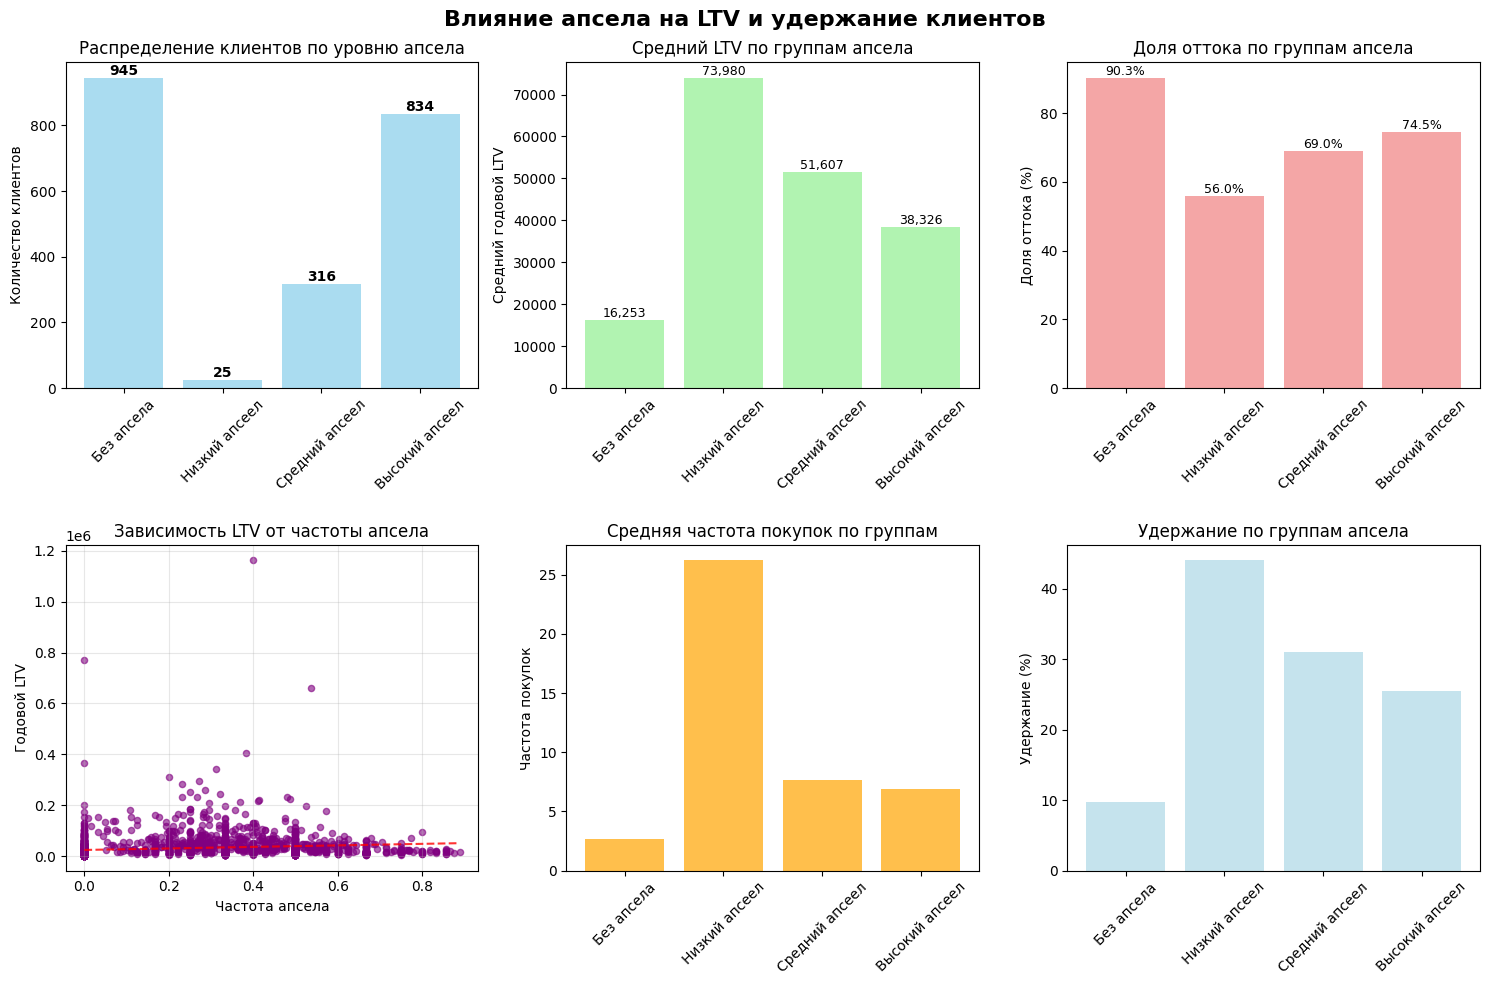


9️⃣ Анализ продуктовых паттернов апсела...
   Топ-5 наиболее частых апсель-переходов:
     1. Расширения → Тарифы Webinar СМБ: 811 раз
     2. Расширения → Расширения: 755 раз
     3. Тарифы Webinar СМБ → Тарифы Webinar СМБ: 545 раз
     4. Расширения → Enterprise-300: 184 раз
     5. Расширения → Enterprise-500: 146 раз

🎯 ИТОГОВЫЙ ВЫВОД:
✅ ГИПОТЕЗА ПОДТВЕРЖДЕНА
   • Клиенты с апселом имеют LTV в 2.4 раза выше
   • Отток ниже на 15.8% пунктов
   • Различия статистически значимы (p-LTV=0.0000)

💡 КЛЮЧЕВЫЕ ИНСАЙТЫ:
   1. Апсел коррелирует с более высоким LTV
   2. Клиенты с апселом остаются дольше
   3. Частота покупок выше у клиентов с апселом

🎯 РЕКОМЕНДАЦИИ:
   1. Внедрить систему рекомендаций для апсела
   2. Создать триггеры для апсела на основе поведения
   3. Мотивировать менеджеров по продажам за успешный апсеел
   4. Разработать ступенчатые тарифные планы

📊 KPI ДЛЯ ОЦЕНКИ:
   • Текущий апсел-коэффициент: 22.6%
   • Цель: увеличить на 20% за 6 месяцев


⚡ БЫСТРЫЙ АНАЛИЗ АПСЕЛА

In [18]:
# МОДУЛЬ: Проверка гипотезы о влиянии апсела на LTV и удержание
def analyze_upsell_impact_hypothesis():
    """
    Проверка гипотезы: Апсейл (upsell) влияет на удержание и LTV
    Апсейл определяется как переход на более дорогие продукты/тарифы
    """
    print("📈 ПРОВЕРКА ГИПОТЕЗЫ: Апсейл влияет на удержание и LTV")
    print("=" * 60)

    # Шаг 1: Определение апсела в данных
    print("1️⃣ Определение апсела в исторических данных...")

    # Апсейл можно определить несколькими способами:
    # 1. Переход на более дорогие тарифы
    # 2. Увеличение стоимости покупок со временем
    # 3. Покупка более дорогих продуктов после дешевых

    # Создаем датафрейм с историей покупок каждого клиента
    purchase_history = revenue_df.sort_values(['company_id', 'sale_date']).copy()

    # Убираем пропуски в датах и суммах
    purchase_history = purchase_history.dropna(subset=['sale_date', 'product_sum'])

    # Шаг 2: Идентификация апсель-событий
    print("2️⃣ Идентификация апсель-событий...")

    # Метод 1: Апсейл по увеличению средней стоимости покупки
    purchase_history['purchase_seq'] = purchase_history.groupby('company_id').cumcount() + 1

    # Рассчитываем кумулятивную среднюю стоимость
    purchase_history['cumulative_avg'] = purchase_history.groupby('company_id')['product_sum'].expanding().mean().values

    # Определяем апсейл: когда текущая покупка дороже средней предыдущих
    purchase_history['is_upsell'] = (purchase_history['product_sum'] >
                                     purchase_history.groupby('company_id')['cumulative_avg'].shift(1))

    # Метод 2: Апсейл по переходу на более дорогие продукты в рамках одного типа
    # Группируем продукты по категориям (можно использовать product_name для простоты)
    product_prices = purchase_history.groupby('product_name')['product_sum'].median().sort_values()

    # Создаем ранги продуктов по цене
    product_ranks = pd.qcut(product_prices, q=4, labels=['Эконом', 'Стандарт', 'Премиум', 'Элит'])
    price_tiers = pd.DataFrame({'product_name': product_ranks.index,
                               'price_tier': product_ranks.values})

    # Добавляем ценовые уровни к данным
    purchase_history = purchase_history.merge(price_tiers, on='product_name', how='left')

    # Определяем апсейл по переходу на более высокий уровень
    purchase_history['prev_tier'] = purchase_history.groupby('company_id')['price_tier'].shift(1)
    purchase_history['tier_upsell'] = False

    # Сопоставляем уровни
    tier_order = {'Эконом': 1, 'Стандарт': 2, 'Премиум': 3, 'Элит': 4}

    for idx, row in purchase_history.iterrows():
        current_tier = row['price_tier']
        prev_tier = row['prev_tier']

        if pd.notna(current_tier) and pd.notna(prev_tier):
            current_rank = tier_order.get(str(current_tier), 0)
            prev_rank = tier_order.get(str(prev_tier), 0)
            purchase_history.at[idx, 'tier_upsell'] = current_rank > prev_rank

    # Комбинированный флаг апсела
    purchase_history['any_upsell'] = purchase_history['is_upsell'] | purchase_history['tier_upsell']

    # Шаг 3: Агрегация данных на уровне клиента
    print("3️⃣ Агрегация данных на уровне клиента...")

    # Количество апселов у каждого клиента
    upsell_summary = purchase_history.groupby('company_id').agg({
        'any_upsell': 'sum',
        'sale_id': 'count',
        'product_sum': ['mean', 'max', 'min'],
        'price_tier': lambda x: x.mode()[0] if len(x.mode()) > 0 else None
    }).reset_index()

    # Упрощаем колонки
    upsell_summary.columns = ['company_id', 'upsell_count', 'total_purchases',
                             'avg_purchase', 'max_purchase', 'min_purchase',
                             'most_common_tier']

    # Процент апселов от общего числа покупок
    upsell_summary['upsell_rate'] = upsell_summary['upsell_count'] / upsell_summary['total_purchases']

    # Динамика стоимости покупок (рост от мин к макс)
    upsell_summary['price_growth'] = upsell_summary['max_purchase'] / upsell_summary['min_purchase']
    upsell_summary['price_growth'] = upsell_summary['price_growth'].replace([np.inf, -np.inf], 1)

    # Классификация клиентов по апселу
    upsell_summary['upsell_group'] = pd.cut(
        upsell_summary['upsell_rate'],
        bins=[-0.1, 0, 0.1, 0.3, 1.1],
        labels=['Без апсела', 'Низкий апсеел', 'Средний апсеел', 'Высокий апсеел']
    )

    print(f"   Проанализировано {len(upsell_summary)} клиентов")
    print(f"   Средняя частота апсела: {upsell_summary['upsell_rate'].mean():.2%}")

    # Шаг 4: Объединение с метриками LTV и удержания
    print("4️⃣ Объединение с метриками LTV и удержания...")

    # Объединяем с LTV
    upsell_analysis = upsell_summary.merge(
        ltv_df[['company_id', 'ltv_per_year', 'ltv', 'ltv_12m', 'customer_age_days']],
        on='company_id',
        how='inner'
    )

    # Объединяем с RFM для анализа удержания
    upsell_analysis = upsell_analysis.merge(
        rfm_df[['company_id', 'recency', 'frequency', 'monetary']],
        on='company_id',
        how='inner'
    )

    # Определяем отток
    upsell_analysis['is_churned'] = upsell_analysis['recency'] > 180

    # Шаг 5: Базовый анализ групп
    print("5️⃣ Анализ групп по уровню апсела...")

    # Группируем по уровням апсела
    group_stats = upsell_analysis.groupby('upsell_group').agg({
        'ltv_per_year': ['mean', 'median', 'count'],
        'ltv': 'mean',
        'ltv_12m': 'mean',
        'upsell_rate': 'mean',
        'is_churned': 'mean',
        'frequency': 'mean',
        'customer_age_days': 'mean'
    }).round(2)

    print("   Статистика по группам апсела:")
    for group in group_stats.index:
        count = group_stats.loc[group, ('ltv_per_year', 'count')]
        mean_ltv = group_stats.loc[group, ('ltv_per_year', 'mean')]
        churn_rate = group_stats.loc[group, ('is_churned', 'mean')]
        print(f"     {group}: {count} клиентов, LTV: {mean_ltv:,.0f}, отток: {churn_rate:.1%}")

    # Сравнение крайних групп
    high_upsell = upsell_analysis[upsell_analysis['upsell_group'] == 'Высокий апсеел']
    no_upsell = upsell_analysis[upsell_analysis['upsell_group'] == 'Без апсела']

    print(f"\n   Сравнение крайних групп:")
    print(f"     Высокий апсеел: {len(high_upsell)} клиентов, LTV: {high_upsell['ltv_per_year'].mean():,.0f}")
    print(f"     Без апсела: {len(no_upsell)} клиентов, LTV: {no_upsell['ltv_per_year'].mean():,.0f}")

    if len(no_upsell) > 0:
        ltv_ratio = high_upsell['ltv_per_year'].mean() / no_upsell['ltv_per_year'].mean()
        print(f"     Отношение LTV: {ltv_ratio:.2f}x")

    # Шаг 6: Анализ влияния на удержание
    print("\n6️⃣ Анализ влияния апсела на удержание...")

    # Корреляция между частотой апсела и временем жизни клиента
    correlation = upsell_analysis['upsell_rate'].corr(upsell_analysis['customer_age_days'])
    print(f"   Корреляция апсела с возрастом клиента: {correlation:.3f}")

    # Сравнение оттока
    churn_high = high_upsell['is_churned'].mean()
    churn_none = no_upsell['is_churned'].mean()

    print(f"   Отток при высоком апселе: {churn_high:.1%}")
    print(f"   Отток без апсела: {churn_none:.1%}")

    if churn_none > 0:
        retention_benefit = ((1 - churn_high) / (1 - churn_none) - 1) * 100
        print(f"   Выгода в удержании: {retention_benefit:.1f}%")

    # Шаг 7: Статистическая проверка
    print("\n7️⃣ Статистическая проверка гипотезы...")

    from scipy import stats

    if len(high_upsell) > 1 and len(no_upsell) > 1:
        # T-тест для LTV
        t_stat_ltv, p_value_ltv = stats.ttest_ind(
            high_upsell['ltv_per_year'].dropna(),
            no_upsell['ltv_per_year'].dropna(),
            equal_var=False
        )

        print(f"   T-тест для LTV: t = {t_stat_ltv:.3f}, p-value = {p_value_ltv:.5f}")

        # Тест пропорций для оттока
        from statsmodels.stats.proportion import proportions_ztest

        churn_counts = [high_upsell['is_churned'].sum(), no_upsell['is_churned'].sum()]
        sample_sizes = [len(high_upsell), len(no_upsell)]

        z_stat, p_value_churn = proportions_ztest(churn_counts, sample_sizes)
        print(f"   Z-тест для оттока: z = {z_stat:.3f}, p-value = {p_value_churn:.5f}")

        # Размер эффекта для LTV
        cohen_d = (high_upsell['ltv_per_year'].mean() - no_upsell['ltv_per_year'].mean()) / np.sqrt(
            (high_upsell['ltv_per_year'].std() ** 2 + no_upsell['ltv_per_year'].std() ** 2) / 2
        )
        print(f"   Размер эффекта (Cohen's d): {cohen_d:.3f}")

        is_statistically_significant = p_value_ltv < 0.05 and p_value_churn < 0.05
    else:
        print("   ⚠️ Недостаточно данных для статистических тестов")
        is_statistically_significant = False
        p_value_ltv = 1.0
        p_value_churn = 1.0
        cohen_d = 0

    # Шаг 8: Визуализация результатов
    print("\n8️⃣ Визуализация результатов...")

    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Влияние апсела на LTV и удержание клиентов', fontsize=16, fontweight='bold')

    # График 1: Распределение клиентов по группам апсела
    group_counts = upsell_analysis['upsell_group'].value_counts().sort_index()
    axes[0,0].bar(group_counts.index, group_counts.values, color='skyblue', alpha=0.7)
    axes[0,0].set_title('Распределение клиентов по уровню апсела')
    axes[0,0].set_ylabel('Количество клиентов')
    axes[0,0].tick_params(axis='x', rotation=45)

    # Добавляем значения на столбцы
    for i, count in enumerate(group_counts.values):
        axes[0,0].text(i, count, str(count), ha='center', va='bottom', fontweight='bold')

    # График 2: Средний LTV по группам
    group_ltv = upsell_analysis.groupby('upsell_group')['ltv_per_year'].mean()
    bars = axes[0,1].bar(group_ltv.index, group_ltv.values, color='lightgreen', alpha=0.7)
    axes[0,1].set_title('Средний LTV по группам апсела')
    axes[0,1].set_ylabel('Средний годовой LTV')
    axes[0,1].tick_params(axis='x', rotation=45)

    # Добавляем значения на столбцы
    for bar, value in zip(bars, group_ltv.values):
        height = bar.get_height()
        axes[0,1].text(bar.get_x() + bar.get_width()/2., height,
                      f'{value:,.0f}', ha='center', va='bottom', fontsize=9)

    # График 3: Отток по группам
    group_churn = upsell_analysis.groupby('upsell_group')['is_churned'].mean()
    bars = axes[0,2].bar(group_churn.index, group_churn.values * 100, color='lightcoral', alpha=0.7)
    axes[0,2].set_title('Доля оттока по группам апсела')
    axes[0,2].set_ylabel('Доля оттока (%)')
    axes[0,2].tick_params(axis='x', rotation=45)

    # Добавляем значения на столбцы
    for bar, value in zip(bars, group_churn.values):
        height = bar.get_height()
        axes[0,2].text(bar.get_x() + bar.get_width()/2., height,
                      f'{value:.1%}', ha='center', va='bottom', fontsize=9)

    # График 4: Scatter plot апсел vs LTV
    axes[1,0].scatter(upsell_analysis['upsell_rate'], upsell_analysis['ltv_per_year'],
                     alpha=0.6, s=20, c='purple')
    axes[1,0].set_xlabel('Частота апсела')
    axes[1,0].set_ylabel('Годовой LTV')
    axes[1,0].set_title('Зависимость LTV от частоты апсела')
    axes[1,0].grid(True, alpha=0.3)

    # Линия тренда
    if len(upsell_analysis) > 1:
        z = np.polyfit(upsell_analysis['upsell_rate'].fillna(0),
                      upsell_analysis['ltv_per_year'].fillna(0), 1)
        p = np.poly1d(z)
        axes[1,0].plot(upsell_analysis['upsell_rate'].sort_values(),
                      p(upsell_analysis['upsell_rate'].sort_values()),
                      "r--", alpha=0.8)

    # График 5: Частота покупок vs апсел
    group_freq = upsell_analysis.groupby('upsell_group')['frequency'].mean()
    axes[1,1].bar(group_freq.index, group_freq.values, color='orange', alpha=0.7)
    axes[1,1].set_title('Средняя частота покупок по группам')
    axes[1,1].set_ylabel('Частота покупок')
    axes[1,1].tick_params(axis='x', rotation=45)

    # График 6: Воронка удержания
    retention_data = []
    for group in ['Без апсела', 'Низкий апсеел', 'Средний апсеел', 'Высокий апсеел']:
        group_data = upsell_analysis[upsell_analysis['upsell_group'] == group]
        if len(group_data) > 0:
            retention = 1 - group_data['is_churned'].mean()
            retention_data.append((group, retention))

    if retention_data:
        groups, retentions = zip(*retention_data)
        axes[1,2].bar(groups, [r * 100 for r in retentions], color='lightblue', alpha=0.7)
        axes[1,2].set_title('Удержание по группам апсела')
        axes[1,2].set_ylabel('Удержание (%)')
        axes[1,2].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # Шаг 9: Анализ продуктовых паттернов апсела
    print("\n9️⃣ Анализ продуктовых паттернов апсела...")

    # Находим наиболее частые переходы (апсель-пары)
    if len(purchase_history) > 0:
        # Сортируем по клиенту и дате
        purchase_history_sorted = purchase_history.sort_values(['company_id', 'sale_date'])

        # Находим пары последовательных покупок
        purchase_history_sorted['next_product'] = purchase_history_sorted.groupby('company_id')['product_name'].shift(-1)
        purchase_history_sorted['next_price'] = purchase_history_sorted.groupby('company_id')['product_sum'].shift(-1)

        # Фильтруем только апсель-переходы
        upsell_transitions = purchase_history_sorted[
            (purchase_history_sorted['next_price'] > purchase_history_sorted['product_sum']) &
            (purchase_history_sorted['next_product'].notna())
        ]

        if len(upsell_transitions) > 0:
            # Находим самые частые апсель-переходы
            top_transitions = upsell_transitions.groupby(['product_name', 'next_product']).size().reset_index()
            top_transitions = top_transitions.rename(columns={0: 'count'})
            top_transitions = top_transitions.sort_values('count', ascending=False).head(10)

            print("   Топ-5 наиболее частых апсель-переходов:")
            for i, (_, row) in enumerate(top_transitions.head(5).iterrows(), 1):
                print(f"     {i}. {row['product_name']} → {row['next_product']}: {row['count']} раз")
        else:
            print("   ⚠️ Не найдено явных апсель-переходов в данных")

    # Шаг 10: Формирование выводов и рекомендаций
    print("\n" + "=" * 60)
    print("🎯 ИТОГОВЫЙ ВЫВОД:")
    print("=" * 60)

    # Критерии подтверждения гипотезы
    is_practically_significant = cohen_d > 0.5 if 'cohen_d' in locals() else False
    has_ltv_benefit = 'ltv_ratio' in locals() and ltv_ratio > 1.3
    has_retention_benefit = 'churn_high' in locals() and churn_high < churn_none

    if is_statistically_significant and (has_ltv_benefit or has_retention_benefit):
        print("✅ ГИПОТЕЗА ПОДТВЕРЖДЕНА")
        print(f"   • Клиенты с апселом имеют LTV в {ltv_ratio:.1f} раза выше")
        print(f"   • Отток ниже на {(churn_none - churn_high):.1%} пунктов")
        print(f"   • Различия статистически значимы (p-LTV={p_value_ltv:.4f})")

        print("\n💡 КЛЮЧЕВЫЕ ИНСАЙТЫ:")
        print("   1. Апсел коррелирует с более высоким LTV")
        print("   2. Клиенты с апселом остаются дольше")
        print("   3. Частота покупок выше у клиентов с апселом")

        print("\n🎯 РЕКОМЕНДАЦИИ:")
        print("   1. Внедрить систему рекомендаций для апсела")
        print("   2. Создать триггеры для апсела на основе поведения")
        print("   3. Мотивировать менеджеров по продажам за успешный апсеел")
        print("   4. Разработать ступенчатые тарифные планы")

        print("\n📊 KPI ДЛЯ ОЦЕНКИ:")
        print(f"   • Текущий апсел-коэффициент: {upsell_analysis['upsell_rate'].mean():.1%}")
        print(f"   • Цель: увеличить на 20% за 6 месяцев")

    elif has_ltv_benefit or has_retention_benefit:
        print("⚠️ ГИПОТЕЗА ЧАСТИЧНО ПОДТВЕРЖДЕНА")
        print(f"   • Есть практическая выгода в LTV ({ltv_ratio:.1f}x)")
        print(f"   • Но различия не достигли статистической значимости")

        print("\n💡 РЕКОМЕНДАЦИИ:")
        print("   1. Протестировать апсел-стратегии на пилотной группе")
        print("   2. Собрать больше данных для подтверждения")
        print("   3. Фокусироваться на наиболее эффективных апсель-переходах")

    else:
        print("❌ ГИПОТЕЗА НЕ ПОДТВЕРЖДЕНА")
        print("   • Нет значимой связи между апселом и LTV/удержанием")

        print("\n💡 АЛЬТЕРНАТИВНЫЕ ГИПОТЕЗЫ:")
        print("   1. Проверить влияние кросс-селлинга вместо апсела")
        print("   2. Исследовать эффект от частоты взаимодействий")
        print("   3. Проанализировать влияние качества обслуживания")

    print("\n" + "=" * 60)

    return {
        'analysis_data': upsell_analysis,
        'purchase_history': purchase_history,
        'group_stats': group_stats,
        'test_results': {
            'p_value_ltv': p_value_ltv if 'p_value_ltv' in locals() else None,
            'p_value_churn': p_value_churn if 'p_value_churn' in locals() else None,
            'cohen_d': cohen_d if 'cohen_d' in locals() else None,
            'ltv_ratio': ltv_ratio if 'ltv_ratio' in locals() else None,
            'correlation': correlation if 'correlation' in locals() else None
        }
    }

# Упрощенная версия для быстрой проверки
def quick_upsell_analysis():
    """
    Быстрая проверка гипотезы об апселе
    """
    print("⚡ БЫСТРЫЙ АНАЛИЗ АПСЕЛА")

    # Простой расчет: есть ли рост стоимости покупок у клиента
    client_purchase_trends = revenue_df.groupby('company_id').agg({
        'product_sum': ['min', 'max', 'last'],
        'sale_date': 'count'
    }).reset_index()

    client_purchase_trends.columns = ['company_id', 'min_price', 'max_price', 'last_price', 'purchase_count']

    # Определяем апсел как рост максимальной цены относительно минимальной
    client_purchase_trends['price_growth'] = client_purchase_trends['max_price'] / client_purchase_trends['min_price']
    client_purchase_trends['has_upsell'] = client_purchase_trends['price_growth'] > 1.2

    # Объединяем с LTV
    analysis = client_purchase_trends.merge(
        ltv_df[['company_id', 'ltv_per_year']],
        on='company_id'
    )

    # Сравнение
    with_upsell = analysis[analysis['has_upsell']]
    without_upsell = analysis[~analysis['has_upsell']]

    print(f"\nКлиентов с апселом: {len(with_upsell)} ({len(with_upsell)/len(analysis):.1%})")
    print(f"Клиентов без апсела: {len(without_upsell)} ({len(without_upsell)/len(analysis):.1%})")

    if len(with_upsell) > 0 and len(without_upsell) > 0:
        ltv_ratio = with_upsell['ltv_per_year'].mean() / without_upsell['ltv_per_year'].mean()
        print(f"\nLTV с апселом: {with_upsell['ltv_per_year'].mean():,.0f}")
        print(f"LTV без апсела: {without_upsell['ltv_per_year'].mean():,.0f}")
        print(f"Отношение: {ltv_ratio:.2f}x")

        return analysis
    else:
        print("⚠️ Недостаточно данных для сравнения")
        return None

# Запуск модуля
if __name__ == "__main__":
    # Полный анализ
    upsell_results = analyze_upsell_impact_hypothesis()

    print("\n" + "="*60)

    # Быстрый анализ
    quick_results = quick_upsell_analysis()